# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import subprocess
from IPython.display import display, Markdown, HTML
import os

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 05 Oct 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "40-49": 10,
        "30-39": 11,
        "18-29": 12,                
        "16-17": 0 
        # NB if the population denominator is not included for the final group (0), the key must contain phrase "not in other eligible groups" so that data is presented appropriately
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"
                                      )]
# under50s
u50 = ["sex", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    u50, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "40-49":    u50,
                 "30-39":    u50,
                 "18-29":    u50,
                 "16-17":    ["sex", "ethnicity_6_groups", "imd_categories"],
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

In [12]:
# for details on second/third doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

df_dict_cum_third_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")

### Cumulative vaccination figures - overall

In [13]:
from report_results import make_vaccine_graphs

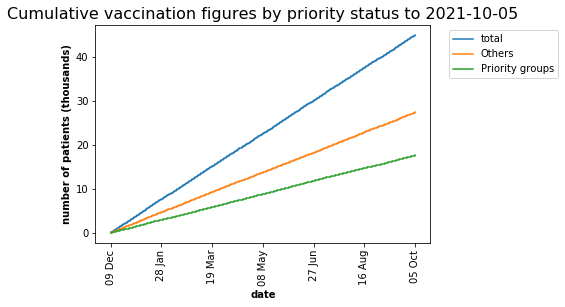

In [14]:
make_vaccine_graphs(df, latest_date=latest_date, grouping="priority_status", savepath_figure_csvs=savepath_figure_csvs, savepath=savepath, suffix=suffix)

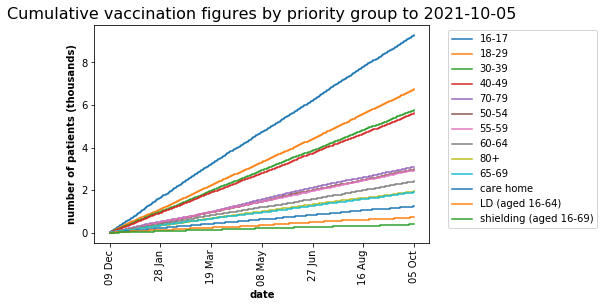

In [15]:
make_vaccine_graphs(df, latest_date=latest_date, include_total=False, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [16]:
from report_results import summarise_data_by_group

In [17]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

In [18]:
summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

summarised_data_dict_3rd_dose = summarise_data_by_group(df_dict_cum_third_dose, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [19]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [20]:
summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [21]:
summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

summ_stat_results_3rd_dose, _ = create_summary_stats(df, summarised_data_dict_3rd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="third_dose", suffix=suffix)

In [22]:
# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)).join(pd.DataFrame(summ_stat_results_3rd_dose)))   
display(Markdown(f"*\n figures rounded to nearest 7"))

,first dose as at 05 Oct 2021,second dose as at 05 Oct 2021,third dose as at 05 Oct 2021
Total vaccinated in TPP,"45,003","39,998","4,998"
80+,"90.0% (1,939 of 2,156)","79.3% (1,708 of 2,156)","9.1% (196 of 2,156)"
70-79,"88.7% (3,101 of 3,500)","80.3% (2,807 of 3,500)","10.9% (378 of 3,500)"
care home,"91.0% (1,239 of 1,358)","79.6% (1,078 of 1,358)","10.8% (147 of 1,358)"
shielding (aged 16-69),92.0% (392 of 427),78.9% (336 of 427),10.1% (42 of 427)
65-69,"90.2% (1,897 of 2,100)","80.5% (1,687 of 2,100)","9.5% (196 of 2,100)"
LD (aged 16-64),90.4% (721 of 798),78.7% (630 of 798),9.9% (77 of 798)
60-64,"90.4% (2,408 of 2,667)","78.9% (2,100 of 2,667)","10.7% (287 of 2,667)"
55-59,"90.2% (2,933 of 3,248)","80.1% (2,604 of 3,248)","9.3% (301 of 3,248)"
50-54,"89.1% (2,975 of 3,339)","80.4% (2,688 of 3,339)","9.3% (308 of 3,339)"


*
 figures rounded to nearest 7

In [23]:
# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

Oxford-AZ vaccines (% of all first doses): **0.1%** (42)

Pfizer vaccines (% of all first doses): **0.2%** (112)

Moderna vaccines (% of all first doses): **0.1%** (35)

Second doses (% of all vaccinated): **88.9%** (39,998)

Second doses (% of Ox-AZ first doses): **6283.3%** (2,639)

Second doses (% of Pfizer first doses): **1131.2%** (1,267)

Second doses (% of Moderna first doses): **8940.0%** (3,129)

Mixed doses Ox-AZ + Pfizer (% of fully vaccinated): **0.0%** (0)

Mixed doses Ox-AZ + Moderna (% of fully vaccinated): **0.0%** (0)

Mixed doses Moderna + Pfizer (% of fully vaccinated): **0.0%** (0)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [24]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout (first dose) among **80+** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1940   
sex                       F                                          1008   
                          M                                           931   
ageband_5yr               0                                            21   
                          0-15                                        140   
                          16-17                                       147   
                          18-29                                       119   
                          30-34                                       133   
                          35-39                                       119   
                          40-44                                       126   
                          45-49                                       126   
                          50-54                                        91   
                          55-59                                       119   
                          60-64                                       133   
                          65-69                                       119   
                          70-74                                       154   
                          75-79                                       119   
                          80-84                                       126   
                          85-89                                       126   
                          90+                                          21   
ethnicity_6_groups        Black                                       322   
                          Mixed                                       308   
                          Other                                       350   
                          South Asian                                 315   
                          Unknown                                     301   
                          White                                       343   
ethnicity_16_groups        African                                    112   
                           Bangladeshi or British Bangladeshi          91   
                           Caribbean                                  105   
                           Chinese                                     84   
                           Other                                       84   
                           Other Asian                                 98   
                          British or Mixed British                    126   
                          Indian or British Indian                    105   
                          Irish                                        98   
                          Other Black                                  98   
                          Other White                                 105   
                          Other mixed                                 112   
                          Pakistani or British Pakistani              105   
                          Unknown                                     287   
                          White + Asian                               112   
                          White + Black African                       112   
                          White + Black Caribbean                      98   
imd_categories            1 Most deprived                             350   
                          2                                           336   
                          3                                           399   
                          4                                           378   
                          5 Least deprived                            371   
                          Unknown                                     105   
bmi                       30+                                         553   
                          under 30                         

## 

## COVID vaccination rollout (first dose) among **70-79** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3104   
sex                       F                                          1617   
                          M                                          1491   
ageband_5yr               0                                            35   
                          0-15                                        224   
                          16-17                                       217   
                          18-29                                       189   
                          30-34                                       189   
                          35-39                                       196   
                          40-44                                       203   
                          45-49                                       196   
                          50-54                                       189   
                          55-59                                       203   
                          60-64                                       189   
                          65-69                                       196   
                          70-74                                       182   
                          75-79                                       224   
                          80-84                                       238   
                          85-89                                       196   
                          90+                                          35   
ethnicity_6_groups        Black                                       539   
                          Mixed                                       532   
                          Other                                       518   
                          South Asian                                 539   
                          Unknown                                     455   
                          White                                       518   
ethnicity_16_groups        African                                    168   
                           Bangladeshi or British Bangladeshi         182   
                           Caribbean                                  175   
                           Chinese                                    161   
                           Other                                      154   
                           Other Asian                                161   
                          British or Mixed British                    154   
                          Indian or British Indian                    161   
                          Irish                                       175   
                          Other Black                                 182   
                          Other White                                 147   
                          Other mixed                                 182   
                          Pakistani or British Pakistani              154   
                          Unknown                                     476   
                          White + Asian                               154   
                          White + Black African                       168   
                          White + Black Caribbean                     161   
imd_categories            1 Most deprived                             623   
                          2                                           602   
                          3                                           546   
                          4                                           574   
                          5 Least deprived                            588   
                          Unknown                                     168   
bmi                       30+                                         931   
                          under 30                         

## 

## COVID vaccination rollout (first dose) among **care home** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1236     91.0   1358   
sex                F                   630     90.9    693   
                   M                   602     90.5    665   
ageband_5yr        0                    14     66.7     21   
                   0-15                 77     91.7     84   
                   16-17                77    100.0     77   
                   18-29                77     84.6     91   
                   30-34                84     92.3     91   
                   35-39                77    100.0     77   
                   40-44                77     91.7     84   
                   45-49                77     91.7     84   
                   50-54                84     92.3     91   
                   55-59                84     85.7     98   
                   60-64                77     91.7     84   
                   65-69                77     91.7     84   
                   70-74               105    100.0    105   
                   75-79                84     92.3     91   
                   80-84                77     91.7     84   
                   85-89                84     92.3     91   
                   90+                  14     66.7     21   
ethnicity_6_groups Black               203     93.5    217   
                   Mixed               189     90.0    210   
                   Other               238     94.4    252   
                   South Asian         196     90.3    217   
                   Unknown             189     93.1    203   
                   White               224     91.4    245   
dementia           no                 1218     91.1   1337   
                   yes                  14    100.0     14   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 88.8   
sex                F                                       87.9   
                   M                                       89.5   
ageband_5yr        0                                       66.7   
                   0-15                                    91.7   
                   16-17                                   90.9   
                   18-29                                   84.6   
                   30-34                                   92.3   
                   35-39                                   90.9   
                   40-44                                   91.7   
                   45-49                                   83.3   
                   50-54                                   92.3   
                   55-59                                   85.7   
                   60-64                                   83.3   
                   65-69                                   91.7   
                   70-74                                   93.3   
                   75-79                                   92.3   
                   80-84                                   83.3   
                   85-89                                   92.3   
                   90+                                     66.7   
ethnicity_6_groups Black                                   90.3   
                   Mixed                                   86.7   
                   Other                                   91.7   
                   South Asian                             87.1   
                   Unknown                                 86.2   
                   White                                   91.4   
dementia           no                                        89   
                   yes                                      100   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

## 

## COVID vaccination rollout (first dose) among **shielding (aged 16-69)** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  393     92.0    427   
newly_shielded_since_feb_15 no                       385     91.7    420   
                            yes                        0      0.0      0   
sex                         F                        196     93.3    210   
                            M                        196     93.3    210   
ageband                     16-29                     49    100.0     49   
                            30-39                     42     85.7     49   
                            40-49                     63    100.0     63   
                            50-59                     49     87.5     56   
                            60-69                     56     88.9     63   
                            70-79                     84     85.7     98   
                            80+                       42     85.7     49   
ethnicity_6_groups          Black                     70     90.9     77   
                            Mixed                     77     91.7     84   
                            Other                     70    100.0     70   
                            South Asian               63     90.0     70   
                            Unknown                   49     87.5     56   
                            White                     70    100.0     70   
imd_categories              1 Most deprived           77     91.7     84   
                            2                         77     91.7     84   
                            3                         77     91.7     84   
                            4                         77     91.7     84   
                            5 Least deprived          70    100.0     70   
                            Unknown                   21    100.0     21   
LD                          no                       385     93.2    413   
                            yes                        7    100.0      7   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      89.2   
newly_shielded_since_feb_15 no                                             90   
                            yes                                           NaN   
sex                         F                                            93.3   
                            M                                              90   
ageband                     16-29                                         100   
                            30-39                                        85.7   
                            40-49                                         100   
                            50-59                                        87.5   
                            60-69                                        88.9   
                            70-79                                        85.7   
                            80+                                          85.7   
ethnicity_6_groups          Black                                        81.8   
                            Mixed                                        83.3   
                            Other                                          90   
                            South Asian                                    90   
                            Unknown                                        75   
                            White                                         100   
imd_categories              1 Most deprived                              91.7   
                            2                                            83.3   
                            3                                            91.7   
                            4                         

## 

## COVID vaccination rollout (first dose) among **65-69** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1894   
sex                       F                                           966   
                          M                                           931   
ethnicity_6_groups        Black                                       336   
                          Mixed                                       315   
                          Other                                       308   
                          South Asian                                 329   
                          Unknown                                     273   
                          White                                       336   
ethnicity_16_groups        African                                    126   
                           Bangladeshi or British Bangladeshi          98   
                           Caribbean                                   98   
                           Chinese                                     91   
                           Other                                      112   
                           Other Asian                                 91   
                          British or Mixed British                     98   
                          Indian or British Indian                    105   
                          Irish                                        98   
                          Other Black                                  84   
                          Other White                                  98   
                          Other mixed                                 112   
                          Pakistani or British Pakistani               98   
                          Unknown                                     273   
                          White + Asian                                98   
                          White + Black African                        98   
                          White + Black Caribbean                     119   
imd_categories            1 Most deprived                             364   
                          2                                           371   
                          3                                           343   
                          4                                           350   
                          5 Least deprived                            364   
                          Unknown                                      98   
bmi                       30+                                         602   
                          under 30                                   1295   
chronic_cardiac_disease   no                                         1876   
                          yes                                          21   
current_copd              no                                         1869   
                          yes                                          21   
dmards                    no                                         1869   
                          yes                                          21   
dementia                  no                                         1876   
                          yes                                          21   
psychosis_schiz_bipolar   no                                         1869   
                          yes                                          28   
LD                        no                                         1855   
                          yes                                          35   
ssri                      no                                         1876   
                          yes                                          21   
chemo_or_radio            no                                         1869   
                          yes                                          28   
lung_cancer               no                               

## 

## COVID vaccination rollout (first dose) among **LD (aged 16-64)** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             721     90.4    798   
sex                F                   378     90.0    420   
                   M                   343     89.1    385   
ageband_5yr        0                     7    100.0      7   
                   0-15                 49    100.0     49   
                   16-17                42     85.7     49   
                   18-29                49     87.5     56   
                   30-34                49    100.0     49   
                   35-39                42     85.7     49   
                   40-44                56     88.9     63   
                   45-49                49     87.5     56   
                   50-54                35     83.3     42   
                   55-59                35     83.3     42   
                   60-64                42     85.7     49   
                   65-69                56     88.9     63   
                   70-74                49     87.5     56   
                   75-79                49     87.5     56   
                   80-84                49     87.5     56   
                   85-89                49     87.5     56   
                   90+                   7    100.0      7   
ethnicity_6_groups Black               133     95.0    140   
                   Mixed               140     90.9    154   
                   Other               133     90.5    147   
                   South Asian         105     83.3    126   
                   Unknown             105     93.8    112   
                   White               112     94.1    119   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 88.2   
sex                F                                       88.3   
                   M                                       87.3   
ageband_5yr        0                                        100   
                   0-15                                    85.7   
                   16-17                                   85.7   
                   18-29                                   87.5   
                   30-34                                    100   
                   35-39                                   85.7   
                   40-44                                   88.9   
                   45-49                                   87.5   
                   50-54                                   83.3   
                   55-59                                   83.3   
                   60-64                                   85.7   
                   65-69                                   88.9   
                   70-74                                   87.5   
                   75-79                                   87.5   
                   80-84                                   87.5   
                   85-89                                   87.5   
                   90+                                      100   
ethnicity_6_groups Black                                     90   
                   Mixed                                   86.4   
                   Other                                   85.7   
                   South Asian                             83.3   
                   Unknown                                 93.8   
                   White                                   88.2   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               2.2   
sex                F                                     1.7   
                   M                                     1.8   
ageband_5yr        0                                       0   
                   0-15           

## 

## COVID vaccination rollout (first dose) among **60-64** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2411   
sex                       F                                          1225   
                          M                                          1183   
ethnicity_6_groups        Black                                       413   
                          Mixed                                       441   
                          Other                                       420   
                          South Asian                                 399   
                          Unknown                                     336   
                          White                                       406   
ethnicity_16_groups        African                                    147   
                           Bangladeshi or British Bangladeshi         133   
                           Caribbean                                  119   
                           Chinese                                    133   
                           Other                                      126   
                           Other Asian                                140   
                          British or Mixed British                    112   
                          Indian or British Indian                    119   
                          Irish                                       126   
                          Other Black                                 112   
                          Other White                                 126   
                          Other mixed                                 133   
                          Pakistani or British Pakistani              140   
                          Unknown                                     371   
                          White + Asian                               119   
                          White + Black African                       133   
                          White + Black Caribbean                     119   
imd_categories            1 Most deprived                             469   
                          2                                           476   
                          3                                           483   
                          4                                           434   
                          5 Least deprived                            441   
                          Unknown                                     112   
bmi                       30+                                         721   
                          under 30                                   1694   
chronic_cardiac_disease   no                                         2380   
                          yes                                          28   
current_copd              no                                         2380   
                          yes                                          28   
dmards                    no                                         2387   
                          yes                                          28   
dementia                  no                                         2387   
                          yes                                          28   
psychosis_schiz_bipolar   no                                         2387   
                          yes                                          28   
ssri                      no                                         2387   
                          yes                                          21   
chemo_or_radio            no                                         2380   
                          yes                                          28   
lung_cancer               no                                         2380   
                          yes                                          35   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose) among **55-59** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    2930   
sex                     F                                          1512   
                        M                                          1414   
ethnicity_6_groups      Black                                       518   
                        Mixed                                       462   
                        Other                                       532   
                        South Asian                                 476   
                        Unknown                                     441   
                        White                                       497   
ethnicity_16_groups      African                                    133   
                         Bangladeshi or British Bangladeshi         147   
                         Caribbean                                  161   
                         Chinese                                    147   
                         Other                                      168   
                         Other Asian                                147   
                        British or Mixed British                    182   
                        Indian or British Indian                    133   
                        Irish                                       189   
                        Other Black                                 154   
                        Other White                                 147   
                        Other mixed                                 175   
                        Pakistani or British Pakistani              161   
                        Unknown                                     441   
                        White + Asian                               140   
                        White + Black African                       140   
                        White + Black Caribbean                     175   
imd_categories          1 Most deprived                             546   
                        2                                           560   
                        3                                           532   
                        4                                           588   
                        5 Least deprived                            546   
                        Unknown                                     161   
bmi                     30+                                         938   
                        under 30                                   1995   
chronic_cardiac_disease no                                         2905   
                        yes                                          28   
current_copd            no                                         2891   
                        yes                                          42   
dmards                  no                                         2898   
                        yes                                          35   
psychosis_schiz_bipolar no                                         2891   
                        yes                                          35   
ssri                    no                                         2912   
                        yes                                          21   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 90.2   3248   
sex                     F                                       89.3   1694   
                        M                                       91.0   1554   
ethnicity_6_groups      Black                                   89.2    581   
                        Mixed                                   90.4    511   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **50-54** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    2974   
sex                     F                                          1484   
                        M                                          1484   
ethnicity_6_groups      Black                                       483   
                        Mixed                                       483   
                        Other                                       532   
                        South Asian                                 511   
                        Unknown                                     441   
                        White                                       525   
ethnicity_16_groups      African                                    175   
                         Bangladeshi or British Bangladeshi         168   
                         Caribbean                                  161   
                         Chinese                                    175   
                         Other                                      175   
                         Other Asian                                168   
                        British or Mixed British                    168   
                        Indian or British Indian                    154   
                        Irish                                       154   
                        Other Black                                 147   
                        Other White                                 133   
                        Other mixed                                 161   
                        Pakistani or British Pakistani              147   
                        Unknown                                     420   
                        White + Asian                               175   
                        White + Black African                       161   
                        White + Black Caribbean                     133   
imd_categories          1 Most deprived                             567   
                        2                                           609   
                        3                                           560   
                        4                                           567   
                        5 Least deprived                            532   
                        Unknown                                     147   
bmi                     30+                                         917   
                        under 30                                   2058   
chronic_cardiac_disease no                                         2940   
                        yes                                          35   
current_copd            no                                         2940   
                        yes                                          35   
dmards                  no                                         2940   
                        yes                                          35   
psychosis_schiz_bipolar no                                         2954   
                        yes                                          21   
ssri                    no                                         2954   
                        yes                                          21   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 89.1   3339   
sex                     F                                       89.1   1666   
                        M                                       88.7   1673   
ethnicity_6_groups      Black                                   90.8    532   
                        Mixed                                   87.3    553   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **40-49** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    5602     89.7   
sex                 F                                          2898     90.4   
                    M                                          2702     88.9   
ethnicity_6_groups  Black                                       917     89.7   
                    Mixed                                       931     89.3   
                    Other                                       987     90.4   
                    South Asian                                 987     87.6   
                    Unknown                                     854     90.4   
                    White                                       924     91.0   
ethnicity_16_groups  African                                    301     93.5   
                     Bangladeshi or British Bangladeshi         287     89.1   
                     Caribbean                                  273     88.6   
                     Chinese                                    315     93.8   
                     Other                                      315     90.0   
                     Other Asian                                273     88.6   
                    British or Mixed British                    280     88.9   
                    Indian or British Indian                    315     93.8   
                    Irish                                       287     87.2   
                    Other Black                                 287     89.1   
                    Other White                                 315     90.0   
                    Other mixed                                 287     87.2   
                    Pakistani or British Pakistani              301     89.6   
                    Unknown                                     847     90.3   
                    White + Asian                               301     86.0   
                    White + Black African                       322     88.5   
                    White + Black Caribbean                     294     91.3   
imd_categories      1 Most deprived                            1092     90.2   
                    2                                          1015     90.1   
                    3                                          1057     89.9   
                    4                                          1134     90.5   
                    5 Least deprived                           1064     89.4   
                    Unknown                                     245     85.4   

                                                         total  \
category            group                                        
overall             overall                               6244   
sex                 F                                     3206   
                    M                                     3038   
ethnicity_6_groups  Black                                 1022   
                    Mixed                                 1043   
                    Other                                 1092   
                    South Asian                           1127   
                    Unknown                                945   
                    White                                 1015   
ethnicity_16_groups  African                               322   
                     Bangladeshi or British Bangladeshi    322   
                     Caribbean                             308   
                     Chinese                               336   
                     Other                                 350   
                     Other Asian                           308   
                    British or Mixed British               315   
                    Indian or British Indian               336   
                    Irish                                  329   
                

## 

## COVID vaccination rollout (first dose) among **30-39** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    5762     90.1   
sex                 F                                          2891     90.6   
                    M                                          2870     89.5   
ethnicity_6_groups  Black                                      1001     89.4   
                    Mixed                                       994     90.4   
                    Other                                       924     89.2   
                    South Asian                                 987     89.2   
                    Unknown                                     868     89.2   
                    White                                       980     92.1   
ethnicity_16_groups  African                                    308     91.7   
                     Bangladeshi or British Bangladeshi         294     89.4   
                     Caribbean                                  308     93.6   
                     Chinese                                    301     91.5   
                     Other                                      301     87.8   
                     Other Asian                                315     88.2   
                    British or Mixed British                    308     89.8   
                    Indian or British Indian                    336     88.9   
                    Irish                                       280     90.9   
                    Other Black                                 294     95.5   
                    Other White                                 294     91.3   
                    Other mixed                                 308     93.6   
                    Pakistani or British Pakistani              343     89.1   
                    Unknown                                     840     88.2   
                    White + Asian                               322     86.8   
                    White + Black African                       315     90.0   
                    White + Black Caribbean                     301     89.6   
imd_categories      1 Most deprived                            1127     90.4   
                    2                                          1113     89.8   
                    3                                          1099     90.8   
                    4                                          1113     89.8   
                    5 Least deprived                           1029     88.6   
                    Unknown                                     273     88.6   

                                                         total  \
category            group                                        
overall             overall                               6398   
sex                 F                                     3192   
                    M                                     3206   
ethnicity_6_groups  Black                                 1120   
                    Mixed                                 1099   
                    Other                                 1036   
                    South Asian                           1106   
                    Unknown                                973   
                    White                                 1064   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             329   
                     Chinese                               329   
                     Other                                 343   
                     Other Asian                           357   
                    British or Mixed British               343   
                    Indian or British Indian               378   
                    Irish                                  308   
                

## 

## COVID vaccination rollout (first dose) among **18-29** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    6747     90.2   
sex                 F                                          3458     90.1   
                    M                                          3290     90.4   
ethnicity_6_groups  Black                                      1120     88.9   
                    Mixed                                      1183     90.9   
                    Other                                      1127     89.9   
                    South Asian                                1176     90.8   
                    Unknown                                     987     89.8   
                    White                                      1155     91.2   
ethnicity_16_groups  African                                    385     91.7   
                     Bangladeshi or British Bangladeshi         392     90.3   
                     Caribbean                                  357     89.5   
                     Chinese                                    371     88.3   
                     Other                                      364     91.2   
                     Other Asian                                371     93.0   
                    British or Mixed British                    322     90.2   
                    Indian or British Indian                    343     90.7   
                    Irish                                       350     92.6   
                    Other Black                                 350     92.6   
                    Other White                                 322     88.5   
                    Other mixed                                 385     88.7   
                    Pakistani or British Pakistani              336     92.3   
                    Unknown                                     994     88.8   
                    White + Asian                               392     90.3   
                    White + Black African                       357     91.1   
                    White + Black Caribbean                     357     89.5   
imd_categories      1 Most deprived                            1253     89.9   
                    2                                          1316     90.4   
                    3                                          1323     90.4   
                    4                                          1330     91.3   
                    5 Least deprived                           1211     89.2   
                    Unknown                                     315     90.0   

                                                         total  \
category            group                                        
overall             overall                               7476   
sex                 F                                     3836   
                    M                                     3640   
ethnicity_6_groups  Black                                 1260   
                    Mixed                                 1302   
                    Other                                 1253   
                    South Asian                           1295   
                    Unknown                               1099   
                    White                                 1267   
ethnicity_16_groups  African                               420   
                     Bangladeshi or British Bangladeshi    434   
                     Caribbean                             399   
                     Chinese                               420   
                     Other                                 399   
                     Other Asian                           399   
                    British or Mixed British               357   
                    Indian or British Indian               378   
                    Irish                                  378   
                

## 

## COVID vaccination rollout (first dose) among **16-17** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                          
overall            overall                 9287     90.3  10290   
sex                F                       4753     90.3   5264   
                   M                       4536     90.3   5026   
ethnicity_6_groups Black                   1540     90.5   1701   
                   Mixed                   1582     91.1   1736   
                   Other                   1568     89.2   1757   
                   South Asian             1645     91.1   1806   
                   Unknown                 1421     89.4   1589   
                   White                   1526     89.7   1701   
imd_categories     1 Most deprived         1820     89.3   2037   
                   2                       1750     89.6   1953   
                   3                       1722     91.4   1883   
                   4                       1722     91.1   1890   
                   5 Least deprived        1820     89.3   2037   
                   Unknown                  448     90.1    497   

                                    vaccinated 7d previous (percent)  \
category           group                                               
overall            overall                                      88.3   
sex                F                                            88.3   
                   M                                            88.4   
ethnicity_6_groups Black                                        88.5   
                   Mixed                                        89.5   
                   Other                                        86.9   
                   South Asian                                  89.1   
                   Unknown                                      87.2   
                   White                                        88.5   
imd_categories     1 Most deprived                              86.9   
                   2                                            88.5   
                   3                                            89.2   
                   4                                            89.6   
                   5 Least deprived                             87.3   
                   Unknown                                      87.3   

                                    Uptake over last 7d (percent)  \
category           group                                            
overall            overall                                      2   
sex                F                                            2   
                   M                                          1.9   
ethnicity_6_groups Black                                        2   
                   Mixed                                      1.6   
                   Other                                      2.3   
                   South Asian                                  2   
                   Unknown                                    2.2   
                   White                                      1.2   
imd_categories     1 Most deprived                            2.4   
                   2                                          1.1   
                   3                                          2.2   
                   4                                          1.5   
                   5 Least deprived                             2   
                   Unknown                                    2.8   

                                    Date projected to reach 90%  
category           group                                         
overall            overall                              reached  
sex                F                                    reached  
                   M                                    reached  
ethnicity_6_groups Black                                reached  
                   Mixed                                reached  
                   Other            

# Demographics time trend charts

In [25]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 05 Oct 2021

### COVID vaccinations among **80+** population by **sex**

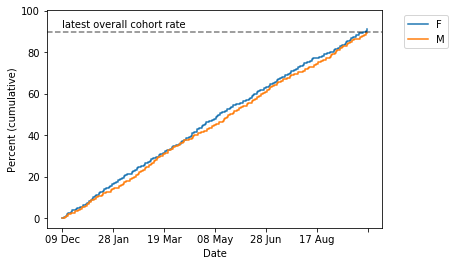

### COVID vaccinations among **80+** population by **ageband 5yr**

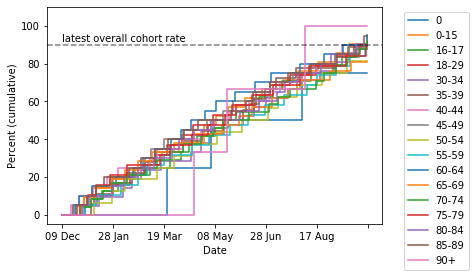

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

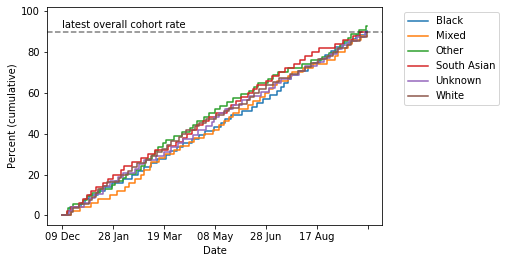

### COVID vaccinations among **80+** population by **imd categories**

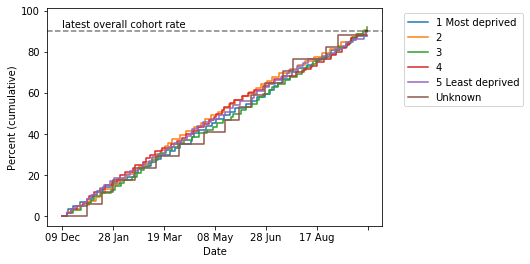

### COVID vaccinations among **80+** population by **bmi**

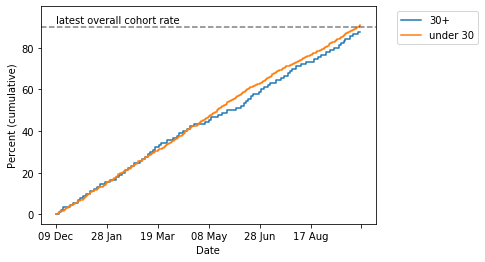

### COVID vaccinations among **80+** population by **dialysis**

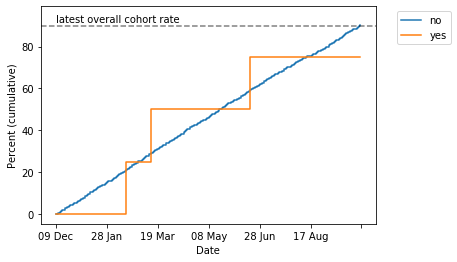

### COVID vaccinations among **80+** population by **dementia**

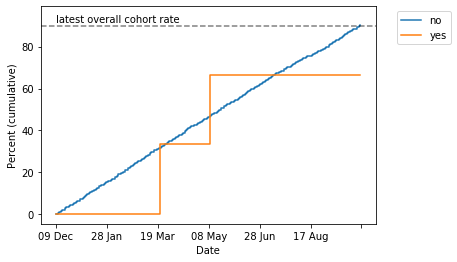

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

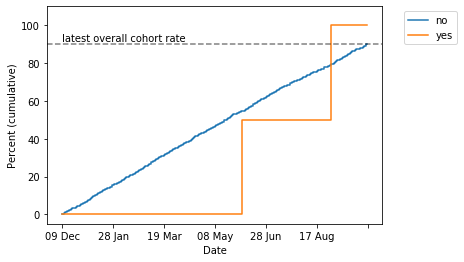

### COVID vaccinations among **80+** population by **LD**

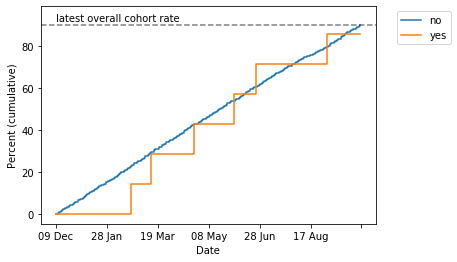

### COVID vaccinations among **80+** population by **ssri**

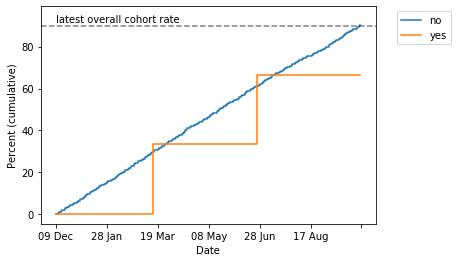

## 
 ## COVID vaccination rollout among **70-79** population up to 05 Oct 2021

### COVID vaccinations among **70-79** population by **sex**

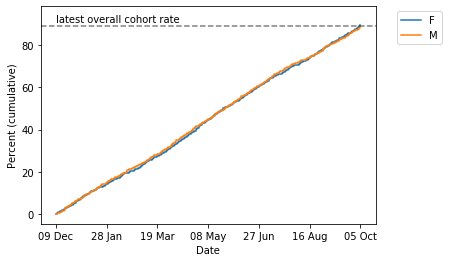

### COVID vaccinations among **70-79** population by **ageband 5yr**

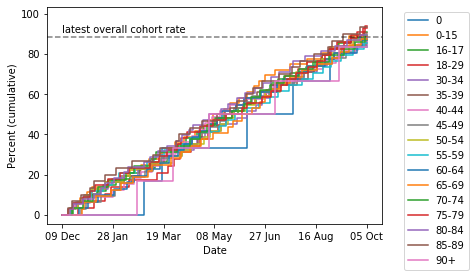

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

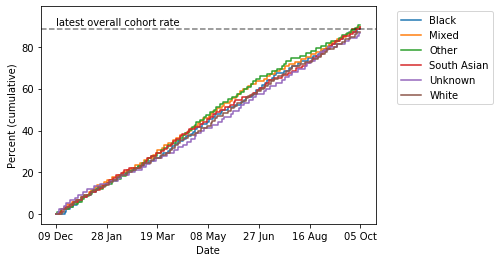

### COVID vaccinations among **70-79** population by **imd categories**

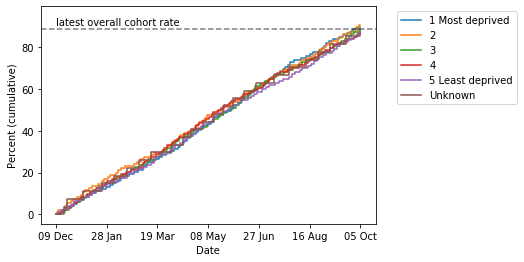

### COVID vaccinations among **70-79** population by **bmi**

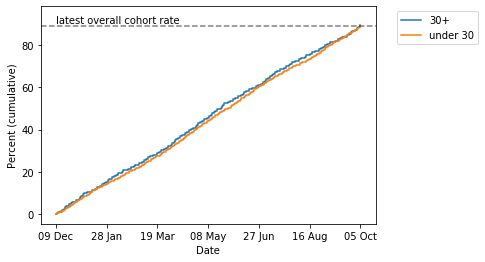

### COVID vaccinations among **70-79** population by **dialysis**

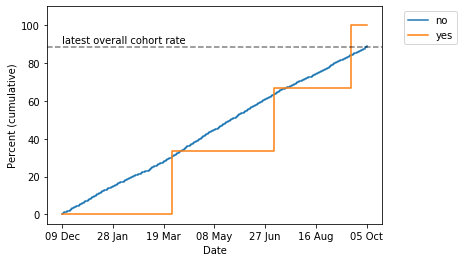

### COVID vaccinations among **70-79** population by **dementia**

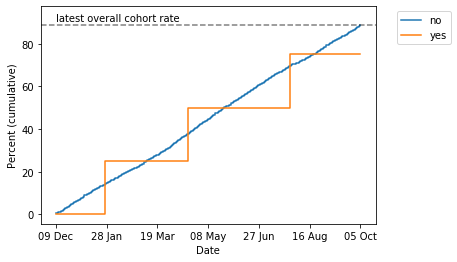

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

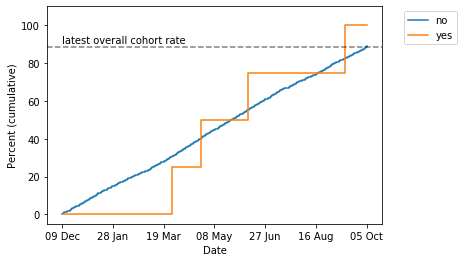

### COVID vaccinations among **70-79** population by **LD**

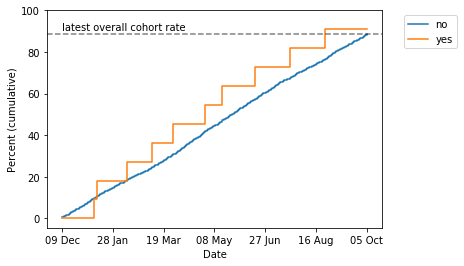

### COVID vaccinations among **70-79** population by **ssri**

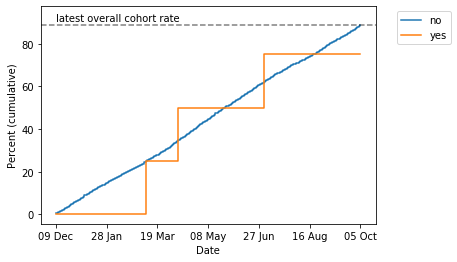

## 
 ## COVID vaccination rollout among **65-69** population up to 05 Oct 2021

### COVID vaccinations among **65-69** population by **sex**

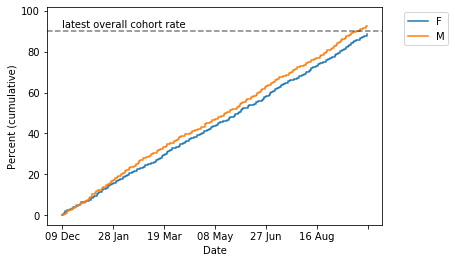

### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

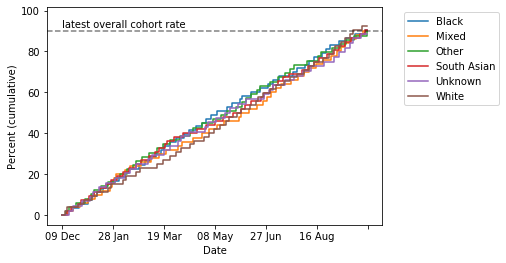

### COVID vaccinations among **65-69** population by **imd categories**

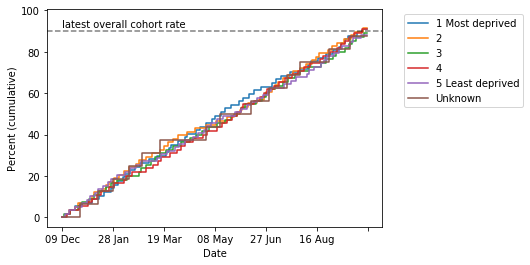

### COVID vaccinations among **65-69** population by **bmi**

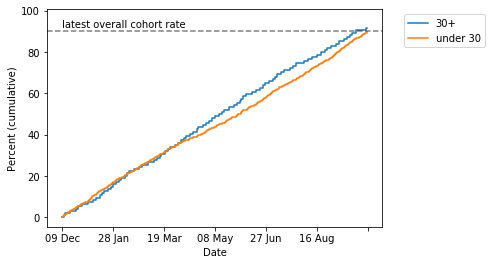

### COVID vaccinations among **65-69** population by **dementia**

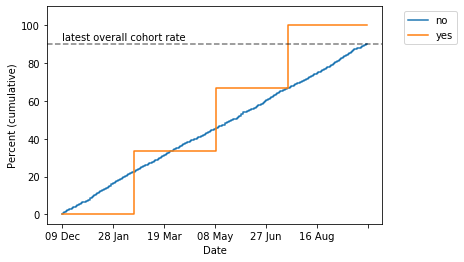

### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

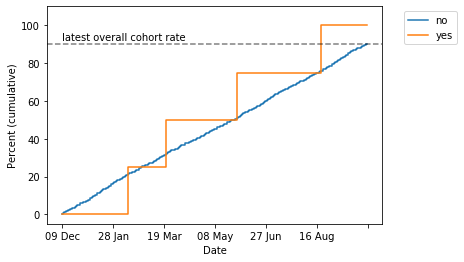

### COVID vaccinations among **65-69** population by **LD**

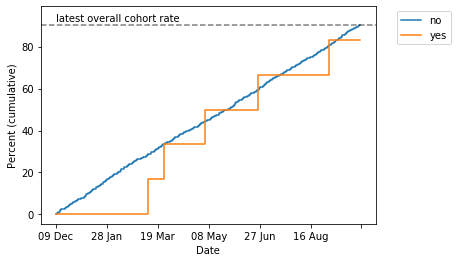

### COVID vaccinations among **65-69** population by **ssri**

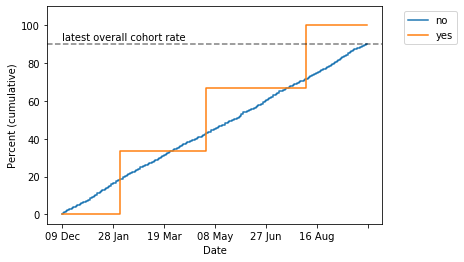

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 05 Oct 2021

### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

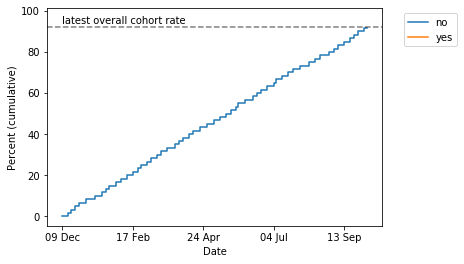

### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

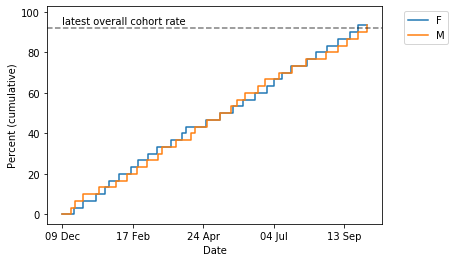

### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

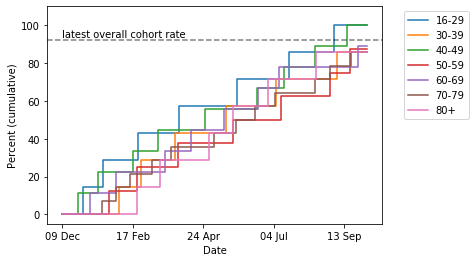

### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

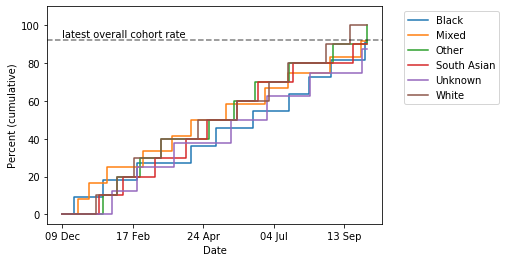

### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

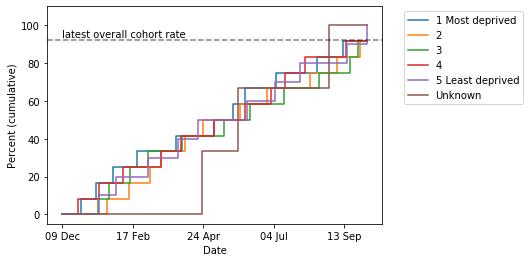

### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

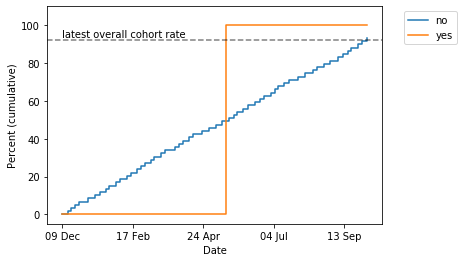

## 
 ## COVID vaccination rollout among **60-64** population up to 05 Oct 2021

### COVID vaccinations among **60-64** population by **sex**

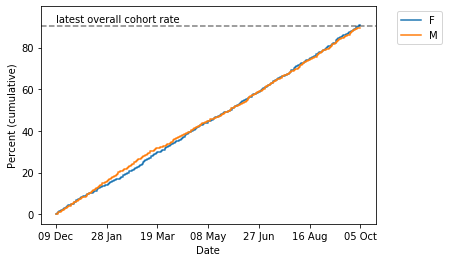

### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

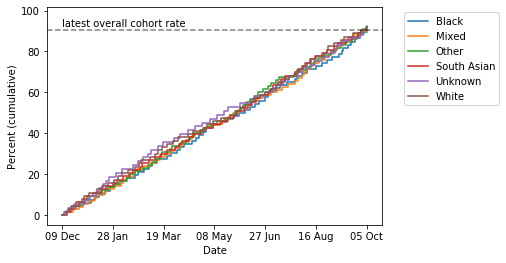

### COVID vaccinations among **60-64** population by **imd categories**

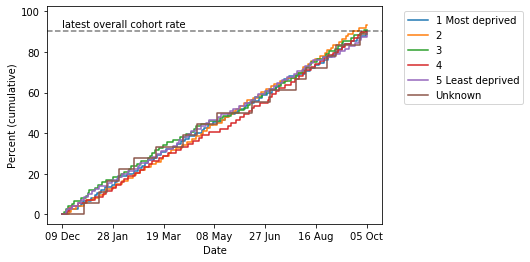

### COVID vaccinations among **60-64** population by **bmi**

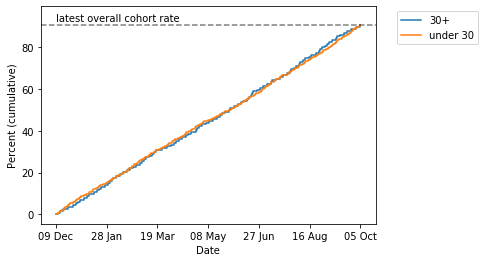

### COVID vaccinations among **60-64** population by **dementia**

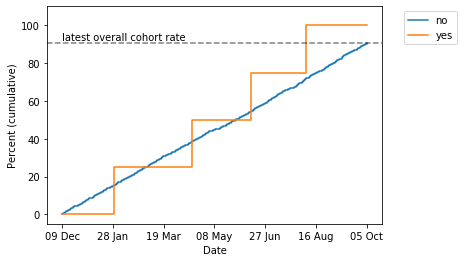

### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

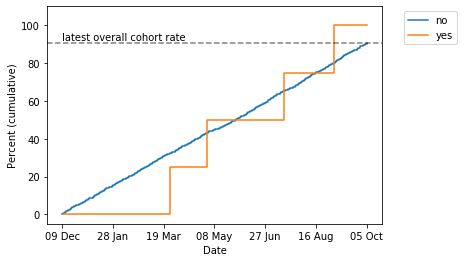

### COVID vaccinations among **60-64** population by **ssri**

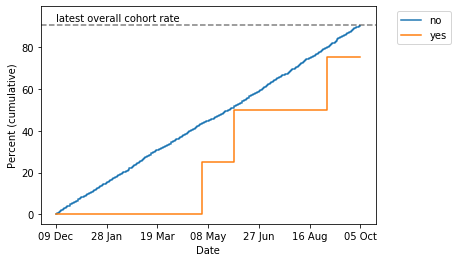

## 
 ## COVID vaccination rollout among **55-59** population up to 05 Oct 2021

### COVID vaccinations among **55-59** population by **sex**

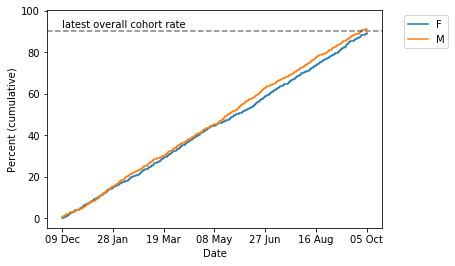

### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

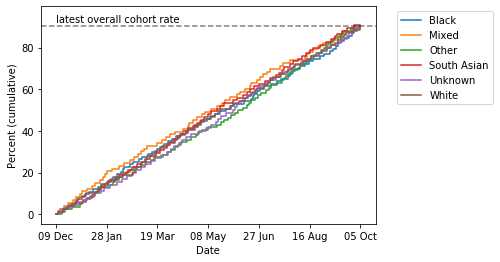

### COVID vaccinations among **55-59** population by **imd categories**

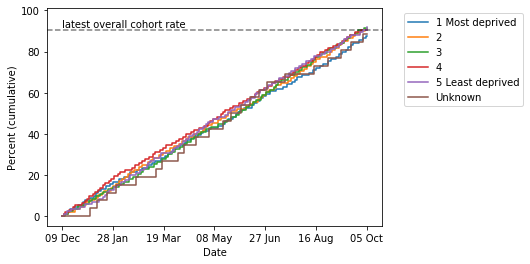

### COVID vaccinations among **55-59** population by **bmi**

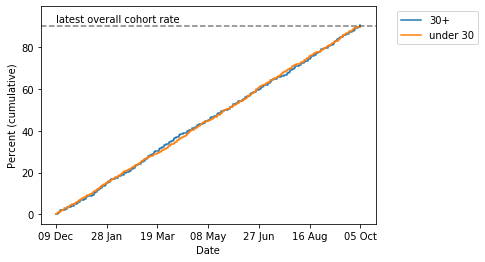

### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

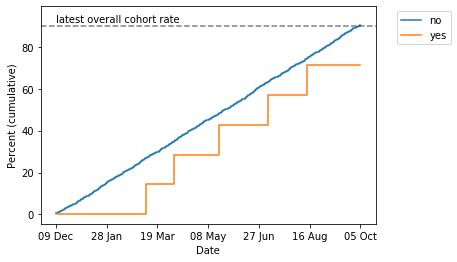

### COVID vaccinations among **55-59** population by **ssri**

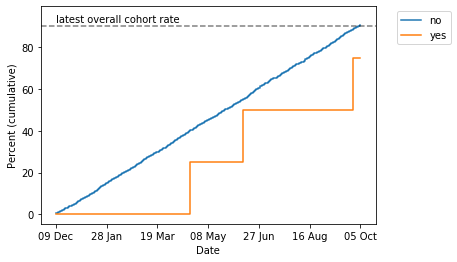

## 
 ## COVID vaccination rollout among **50-54** population up to 05 Oct 2021

### COVID vaccinations among **50-54** population by **sex**

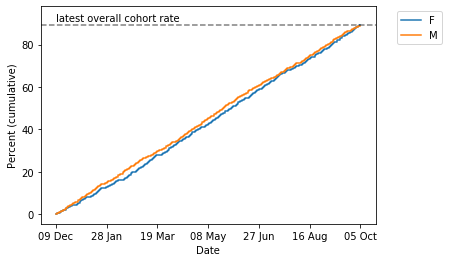

### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

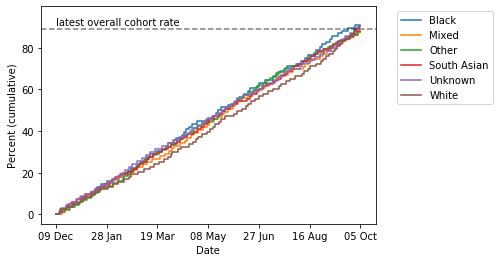

### COVID vaccinations among **50-54** population by **imd categories**

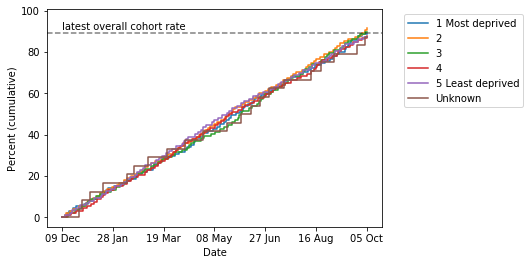

### COVID vaccinations among **50-54** population by **bmi**

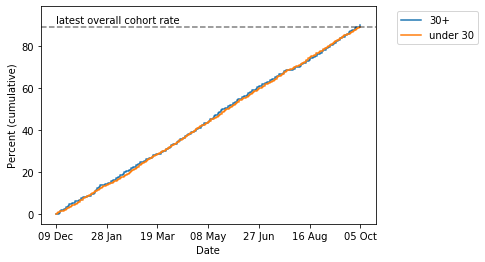

### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

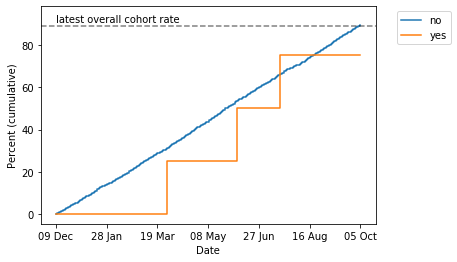

### COVID vaccinations among **50-54** population by **ssri**

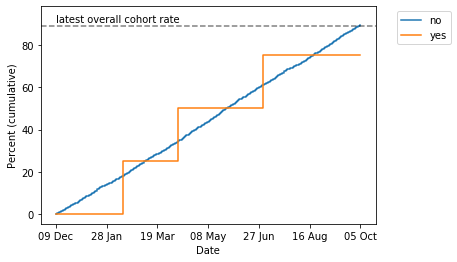

## 
 ## COVID vaccination rollout among **40-49** population up to 05 Oct 2021

### COVID vaccinations among **40-49** population by **sex**

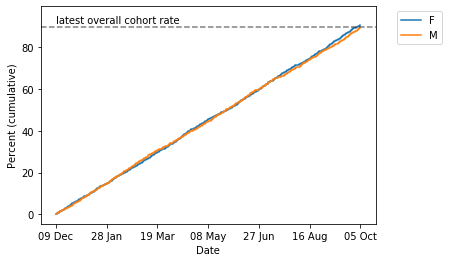

### COVID vaccinations among **40-49** population by **ethnicity 6 groups**

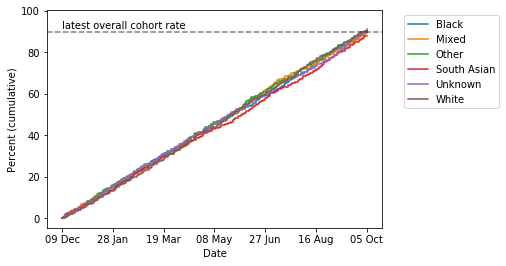

### COVID vaccinations among **40-49** population by **imd categories**

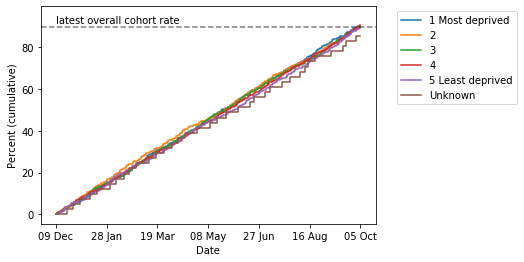

## 
 ## COVID vaccination rollout among **30-39** population up to 05 Oct 2021

### COVID vaccinations among **30-39** population by **sex**

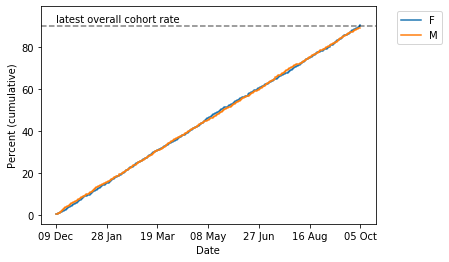

### COVID vaccinations among **30-39** population by **ethnicity 6 groups**

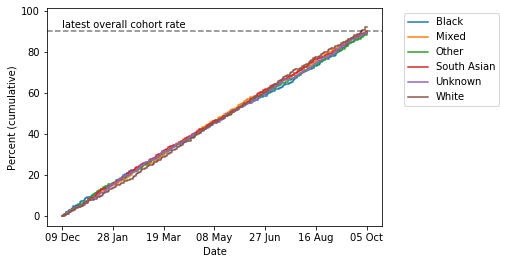

### COVID vaccinations among **30-39** population by **imd categories**

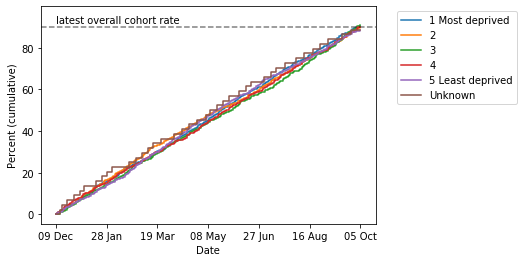

## 
 ## COVID vaccination rollout among **18-29** population up to 05 Oct 2021

### COVID vaccinations among **18-29** population by **sex**

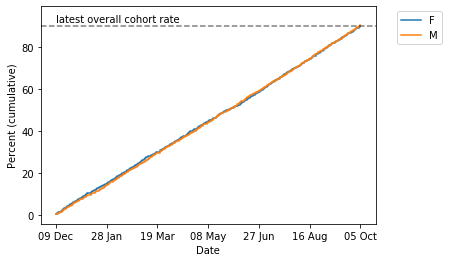

### COVID vaccinations among **18-29** population by **ethnicity 6 groups**

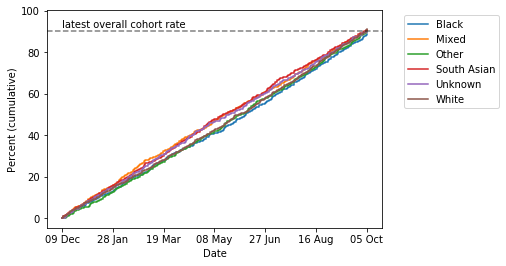

### COVID vaccinations among **18-29** population by **imd categories**

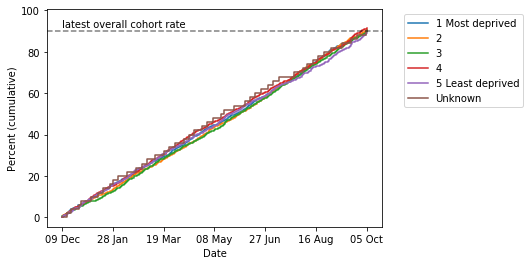

In [26]:
plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54", "40-49", "30-39", "18-29"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "current_copd", "chronic_cardiac_disease", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [27]:
from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


Total **80+** population with ethnicity recorded 1,820 (84.4%)

Total **70-79** population with ethnicity recorded 2,975 (85.0%)

Total **care home** population with ethnicity recorded 1,148 (84.5%)

Total **shielding (aged 16-69)** population with ethnicity recorded 371 (86.9%)

Total **65-69** population with ethnicity recorded 1,792 (85.3%)

Total **LD (aged 16-64)** population with ethnicity recorded 686 (86.0%)

Total **60-64** population with ethnicity recorded 2,296 (86.1%)

Total **55-59** population with ethnicity recorded 2,751 (84.7%)

Total **50-54** population with ethnicity recorded 2,849 (85.3%)

Total **40-49** population with ethnicity recorded 5,299 (84.9%)

Total **30-39** population with ethnicity recorded 5,425 (84.8%)

Total **18-29** population with ethnicity recorded 6,377 (85.3%)

Total **16-17** population with ethnicity recorded 8,701 (84.6%)

# Second doses

In [28]:
# only count second doses where the first dose was given at least 14 weeks ago 
# to allow comparison of the first dose situation 14w ago with the second dose situation now
# otherwise bias could be introduced from any second doses given early in certain subgroups

date_14w = pd.to_datetime(df["covid_vacc_date"]).max() - timedelta(weeks=14)
date_14w = str(date_14w)[:10]

df_s = df.copy()
# replace any second doses not yet "due" with "0"
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) >= date_14w), "covid_vacc_second_dose_date"] = 0

# also ensure that first dose was dated after the start of the campaign, otherwise date is likely incorrect 
# and due date for second dose cannot be calculated accurately
# this also excludes any second doses where first dose date = 0 (this should affect dummy data only!)
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_second_dose_date"] = 0

formatted_date_14w = datetime.strptime(date_14w, "%Y-%m-%d").strftime("%d %b %Y")
with open(os.path.join(savepath["text"], f"latest_date_of_first_dose_for_due_second_doses.txt"), "w") as text_file:
        text_file.write(formatted_date_14w)
        
display(Markdown(formatted_date_14w))

29 Jun 2021

In [29]:
# add "brand of first dose" to list of features to break down by
import copy
features_dict_2 = copy.deepcopy(features_dict)

for k in features_dict_2:
    ls = list(features_dict_2[k])
    ls.append("brand_of_first_dose") 
    features_dict_2[k] = ls

In [30]:

df_dict_cum_second_dose = cumulative_sums(df_s, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

In [31]:
second_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

In [32]:
create_detailed_summary_uptake(second_dose_summarised_data_dict, formatted_latest_date, 
                               groups=groups,
                               savepath=savepath, vaccine_type="second_dose")

## 

## COVID vaccination rollout (second dose) among **80+** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1065   
sex                       F                                           546   
                          M                                           518   
ageband_5yr               0                                            14   
                          0-15                                         70   
                          16-17                                        84   
                          18-29                                        63   
                          30-34                                        70   
                          35-39                                        63   
                          40-44                                        70   
                          45-49                                        77   
                          50-54                                        49   
                          55-59                                        63   
                          60-64                                        77   
                          65-69                                        70   
                          70-74                                        77   
                          75-79                                        70   
                          80-84                                        63   
                          85-89                                        77   
                          90+                                           7   
ethnicity_6_groups        Black                                       168   
                          Mixed                                       161   
                          Other                                       203   
                          South Asian                                 175   
                          Unknown                                     161   
                          White                                       196   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          49   
                           Caribbean                                   70   
                           Chinese                                     49   
                           Other                                       42   
                           Other Asian                                 56   
                          British or Mixed British                     63   
                          Indian or British Indian                     70   
                          Irish                                        56   
                          Other Black                                  56   
                          Other White                                  49   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               49   
                          Unknown                                     161   
                          White + Asian                                56   
                          White + Black African                        70   
                          White + Black Caribbean                      56   
imd_categories            1 Most deprived                             189   
                          2                                           196   
                          3                                           210   
                          4                                           217   
                          5 Least deprived                            203   
                          Unknown                                      49   
bmi                       30+                                         301   
                          under 30                         

## 

## COVID vaccination rollout (second dose) among **70-79** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1731   
sex                       F                                           889   
                          M                                           840   
ageband_5yr               0                                            21   
                          0-15                                        140   
                          16-17                                       119   
                          18-29                                       105   
                          30-34                                       105   
                          35-39                                       112   
                          40-44                                       112   
                          45-49                                       105   
                          50-54                                       105   
                          55-59                                       112   
                          60-64                                       105   
                          65-69                                       105   
                          70-74                                        98   
                          75-79                                       119   
                          80-84                                       140   
                          85-89                                       112   
                          90+                                          21   
ethnicity_6_groups        Black                                       294   
                          Mixed                                       308   
                          Other                                       301   
                          South Asian                                 294   
                          Unknown                                     245   
                          White                                       287   
ethnicity_16_groups        African                                     91   
                           Bangladeshi or British Bangladeshi          98   
                           Caribbean                                   91   
                           Chinese                                     91   
                           Other                                       84   
                           Other Asian                                 84   
                          British or Mixed British                     91   
                          Indian or British Indian                     84   
                          Irish                                        91   
                          Other Black                                  98   
                          Other White                                  84   
                          Other mixed                                  98   
                          Pakistani or British Pakistani               84   
                          Unknown                                     280   
                          White + Asian                                91   
                          White + Black African                        91   
                          White + Black Caribbean                      91   
imd_categories            1 Most deprived                             343   
                          2                                           329   
                          3                                           308   
                          4                                           322   
                          5 Least deprived                            336   
                          Unknown                                      91   
bmi                       30+                                         525   
                          under 30                         

## 

## COVID vaccination rollout (second dose) among **care home** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             666     49.0   1358   
sex                 F                   343     49.5    693   
                    M                   322     48.4    665   
ageband_5yr         0                     0      0.0     21   
                    0-15                 42     50.0     84   
                    16-17                42     54.5     77   
                    18-29                42     46.2     91   
                    30-34                49     53.8     91   
                    35-39                42     54.5     77   
                    40-44                42     50.0     84   
                    45-49                35     41.7     84   
                    50-54                49     53.8     91   
                    55-59                49     50.0     98   
                    60-64                42     50.0     84   
                    65-69                42     50.0     84   
                    70-74                63     60.0    105   
                    75-79                49     53.8     91   
                    80-84                42     50.0     84   
                    85-89                35     38.5     91   
                    90+                   7     33.3     21   
ethnicity_6_groups  Black               105     48.4    217   
                    Mixed                91     43.3    210   
                    Other               133     52.8    252   
                    South Asian         105     48.4    217   
                    Unknown             105     51.7    203   
                    White               126     51.4    245   
dementia            no                  658     49.2   1337   
                    yes                   7     50.0     14   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown             665     54.0   1232   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 47.5   
sex                 F                                       48.5   
                    M                                       47.4   
ageband_5yr         0                                          0   
                    0-15                                      50   
                    16-17                                   54.5   
                    18-29                                   46.2   
                    30-34                                   53.8   
                    35-39                                   54.5   
                    40-44                                     50   
                    45-49                                   41.7   
                    50-54                                   53.8   
                    55-59                                     50   
                    60-64                                     50   
                    65-69                                   41.7   
                    70-74                                     60   
                    75-79                                   46.2   
                    80-84                                   41.7   
                    85-89                                   38.5   
                    90+                                     33.3   
ethnicity_6_groups  Black                                   45.2   
                    Mixed                                   43.3   
                    Other                                     50   
                    South Asian                             48.4   
                    Unknown                                 51.7   
                    White                                   51.4   
dementia            no                                      47.6   
                    yes                     

## 

## COVID vaccination rollout (second dose) among **shielding (aged 16-69)** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  213     49.9    427   
newly_shielded_since_feb_15 no                       210     50.0    420   
                            yes                        0      0.0      0   
sex                         F                        105     50.0    210   
                            M                        105     50.0    210   
ageband                     16-29                     28     57.1     49   
                            30-39                     21     42.9     49   
                            40-49                     35     55.6     63   
                            50-59                     28     50.0     56   
                            60-69                     35     55.6     63   
                            70-79                     49     50.0     98   
                            80+                       21     42.9     49   
ethnicity_6_groups          Black                     28     36.4     77   
                            Mixed                     49     58.3     84   
                            Other                     42     60.0     70   
                            South Asian               35     50.0     70   
                            Unknown                   28     50.0     56   
                            White                     35     50.0     70   
imd_categories              1 Most deprived           42     50.0     84   
                            2                         42     50.0     84   
                            3                         42     50.0     84   
                            4                         42     50.0     84   
                            5 Least deprived          35     50.0     70   
                            Unknown                    7     33.3     21   
LD                          no                       203     49.2    413   
                            yes                        7    100.0      7   
brand_of_first_dose         Unknown                  210     53.6    392   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      48.7   
newly_shielded_since_feb_15 no                                           48.3   
                            yes                                           NaN   
sex                         F                                              50   
                            M                                              50   
ageband                     16-29                                        57.1   
                            30-39                                        42.9   
                            40-49                                        44.4   
                            50-59                                          50   
                            60-69                                        55.6   
                            70-79                                          50   
                            80+                                          42.9   
ethnicity_6_groups          Black                                        36.4   
                            Mixed                                          50   
                            Other                                          60   
                            South Asian                                    40   
                            Unknown                                        50   
                            White                                          50   
imd_categories              1 Most deprived                                50   
                            2                                              50   
                            3                              

## 

## COVID vaccination rollout (second dose) among **65-69** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1039   
sex                       F                                           511   
                          M                                           525   
ethnicity_6_groups        Black                                       189   
                          Mixed                                       161   
                          Other                                       182   
                          South Asian                                 182   
                          Unknown                                     154   
                          White                                       168   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          49   
                           Caribbean                                   63   
                           Chinese                                     49   
                           Other                                       63   
                           Other Asian                                 56   
                          British or Mixed British                     56   
                          Indian or British Indian                     56   
                          Irish                                        49   
                          Other Black                                  49   
                          Other White                                  63   
                          Other mixed                                  63   
                          Pakistani or British Pakistani               56   
                          Unknown                                     140   
                          White + Asian                                49   
                          White + Black African                        49   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             196   
                          2                                           203   
                          3                                           196   
                          4                                           189   
                          5 Least deprived                            196   
                          Unknown                                      56   
bmi                       30+                                         343   
                          under 30                                    700   
chronic_cardiac_disease   no                                         1029   
                          yes                                          14   
current_copd              no                                         1029   
                          yes                                          14   
dmards                    no                                         1029   
                          yes                                           7   
dementia                  no                                         1022   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1022   
                          yes                                          21   
LD                        no                                         1015   
                          yes                                          21   
ssri                      no                                         1029   
                          yes                                          14   
chemo_or_radio            no                                         1029   
                          yes                                           7   
lung_cancer               no                               

## 

## COVID vaccination rollout (second dose) among **LD (aged 16-64)** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             379     47.5    798   
sex                 F                   203     48.3    420   
                    M                   175     45.5    385   
ageband_5yr         0                     0      0.0      7   
                    0-15                 28     57.1     49   
                    16-17                28     57.1     49   
                    18-29                21     37.5     56   
                    30-34                21     42.9     49   
                    35-39                21     42.9     49   
                    40-44                28     44.4     63   
                    45-49                28     50.0     56   
                    50-54                21     50.0     42   
                    55-59                14     33.3     42   
                    60-64                21     42.9     49   
                    65-69                35     55.6     63   
                    70-74                21     37.5     56   
                    75-79                21     37.5     56   
                    80-84                21     37.5     56   
                    85-89                28     50.0     56   
                    90+                   0      0.0      7   
ethnicity_6_groups  Black                70     50.0    140   
                    Mixed                77     50.0    154   
                    Other                70     47.6    147   
                    South Asian          56     44.4    126   
                    Unknown              56     50.0    112   
                    White                56     47.1    119   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown             378     52.9    714   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 46.4   
sex                 F                                       46.7   
                    M                                       45.5   
ageband_5yr         0                                          0   
                    0-15                                    57.1   
                    16-17                                   57.1   
                    18-29                                   37.5   
                    30-34                                   42.9   
                    35-39                                   42.9   
                    40-44                                   44.4   
                    45-49                                     50   
                    50-54                                     50   
                    55-59                                   33.3   
                    60-64                                   42.9   
                    65-69                                   44.4   
                    70-74                                   37.5   
                    75-79                                   37.5   
                    80-84                                   37.5   
                    85-89                                     50   
                    90+                                        0   
ethnicity_6_groups  Black                                     45   
                    Mixed                                   45.5   
                    Other                                   47.6   
                    South Asian                             44.4   
                    Unknown                                   50   
                    White                                   47.1   
brand_of_first_dose Pfizer                                   NaN   
                    Unknown                                   52   

                                Uptake over last 7d (percent)  \
category            group           

## 

## COVID vaccination rollout (second dose) among **60-64** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1253   
sex                       F                                           616   
                          M                                           637   
ethnicity_6_groups        Black                                       217   
                          Mixed                                       231   
                          Other                                       224   
                          South Asian                                 203   
                          Unknown                                     175   
                          White                                       203   
ethnicity_16_groups        African                                     70   
                           Bangladeshi or British Bangladeshi          70   
                           Caribbean                                   63   
                           Chinese                                     70   
                           Other                                       49   
                           Other Asian                                 77   
                          British or Mixed British                     56   
                          Indian or British Indian                     63   
                          Irish                                        70   
                          Other Black                                  70   
                          Other White                                  56   
                          Other mixed                                  70   
                          Pakistani or British Pakistani               77   
                          Unknown                                     196   
                          White + Asian                                56   
                          White + Black African                        70   
                          White + Black Caribbean                      56   
imd_categories            1 Most deprived                             238   
                          2                                           245   
                          3                                           259   
                          4                                           217   
                          5 Least deprived                            238   
                          Unknown                                      56   
bmi                       30+                                         378   
                          under 30                                    875   
chronic_cardiac_disease   no                                         1239   
                          yes                                          14   
current_copd              no                                         1239   
                          yes                                          14   
dmards                    no                                         1239   
                          yes                                          14   
dementia                  no                                         1239   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1239   
                          yes                                          14   
ssri                      no                                         1239   
                          yes                                          14   
chemo_or_radio            no                                         1232   
                          yes                                          21   
lung_cancer               no                                         1239   
                          yes                                          14   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (second dose) among **55-59** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1595   
sex                     F                                           805   
                        M                                           784   
ethnicity_6_groups      Black                                       280   
                        Mixed                                       273   
                        Other                                       280   
                        South Asian                                 259   
                        Unknown                                     231   
                        White                                       266   
ethnicity_16_groups      African                                     77   
                         Bangladeshi or British Bangladeshi          98   
                         Caribbean                                   84   
                         Chinese                                     77   
                         Other                                       98   
                         Other Asian                                 77   
                        British or Mixed British                     98   
                        Indian or British Indian                     56   
                        Irish                                       112   
                        Other Black                                  84   
                        Other White                                  77   
                        Other mixed                                  98   
                        Pakistani or British Pakistani               77   
                        Unknown                                     245   
                        White + Asian                                70   
                        White + Black African                        63   
                        White + Black Caribbean                      91   
imd_categories          1 Most deprived                             294   
                        2                                           301   
                        3                                           287   
                        4                                           336   
                        5 Least deprived                            294   
                        Unknown                                      91   
bmi                     30+                                         497   
                        under 30                                   1099   
chronic_cardiac_disease no                                         1582   
                        yes                                          14   
current_copd            no                                         1575   
                        yes                                          21   
dmards                  no                                         1575   
                        yes                                          21   
psychosis_schiz_bipolar no                                         1575   
                        yes                                          21   
ssri                    no                                         1589   
                        yes                                           7   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    1589   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 49.1   3248   
sex                     F                                       47.5   1694   
                        M                                       50.5 

## 

## COVID vaccination rollout (second dose) among **50-54** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1615   
sex                     F                                           798   
                        M                                           819   
ethnicity_6_groups      Black                                       252   
                        Mixed                                       266   
                        Other                                       315   
                        South Asian                                 287   
                        Unknown                                     231   
                        White                                       266   
ethnicity_16_groups      African                                     91   
                         Bangladeshi or British Bangladeshi          98   
                         Caribbean                                   84   
                         Chinese                                     91   
                         Other                                       98   
                         Other Asian                                 77   
                        British or Mixed British                     91   
                        Indian or British Indian                     98   
                        Irish                                        70   
                        Other Black                                  91   
                        Other White                                  77   
                        Other mixed                                  91   
                        Pakistani or British Pakistani               91   
                        Unknown                                     224   
                        White + Asian                                98   
                        White + Black African                        91   
                        White + Black Caribbean                      56   
imd_categories          1 Most deprived                             294   
                        2                                           336   
                        3                                           301   
                        4                                           315   
                        5 Least deprived                            294   
                        Unknown                                      77   
bmi                     30+                                         504   
                        under 30                                   1113   
chronic_cardiac_disease no                                         1596   
                        yes                                          14   
current_copd            no                                         1596   
                        yes                                          21   
dmards                  no                                         1596   
                        yes                                          21   
psychosis_schiz_bipolar no                                         1603   
                        yes                                          14   
ssri                    no                                         1596   
                        yes                                          14   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    1610   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 48.4   3339   
sex                     F                                       47.9   16

## 

## COVID vaccination rollout (second dose) among **40-49** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3018     48.3   
sex                 F                                          1533     47.8   
                    M                                          1484     48.8   
ethnicity_6_groups  Black                                       490     47.9   
                    Mixed                                       525     50.3   
                    Other                                       525     48.1   
                    South Asian                                 518     46.0   
                    Unknown                                     455     48.1   
                    White                                       504     49.7   
ethnicity_16_groups  African                                    154     47.8   
                     Bangladeshi or British Bangladeshi         168     52.2   
                     Caribbean                                  154     50.0   
                     Chinese                                    161     47.9   
                     Other                                      175     50.0   
                     Other Asian                                147     47.7   
                    British or Mixed British                    154     48.9   
                    Indian or British Indian                    168     50.0   
                    Irish                                       154     46.8   
                    Other Black                                 154     47.8   
                    Other White                                 168     48.0   
                    Other mixed                                 154     46.8   
                    Pakistani or British Pakistani              168     50.0   
                    Unknown                                     448     47.8   
                    White + Asian                               168     48.0   
                    White + Black African                       168     46.2   
                    White + Black Caribbean                     161     50.0   
imd_categories      1 Most deprived                             609     50.3   
                    2                                           560     49.7   
                    3                                           574     48.8   
                    4                                           588     46.9   
                    5 Least deprived                            560     47.1   
                    Unknown                                     126     43.9   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        7     50.0   
                    Unknown                                    3003     53.8   

                                                         total  \
category            group                                        
overall             overall                               6244   
sex                 F                                     3206   
                    M                                     3038   
ethnicity_6_groups  Black                                 1022   
                    Mixed                                 1043   
                    Other                                 1092   
                    South Asian                           1127   
                    Unknown                                945   
                    White                                 1015   
ethnicity_16_groups  African                               322   
                     Bangladeshi or British Bangladeshi    322   
                     Caribbean                             308   
                     Chinese                               336   
                     Other

## 

## COVID vaccination rollout (second dose) among **30-39** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3110     48.6   
sex                 F                                          1547     48.5   
                    M                                          1561     48.7   
ethnicity_6_groups  Black                                       539     48.1   
                    Mixed                                       546     49.7   
                    Other                                       504     48.6   
                    South Asian                                 532     48.1   
                    Unknown                                     469     48.2   
                    White                                       525     49.3   
ethnicity_16_groups  African                                    161     47.9   
                     Bangladeshi or British Bangladeshi         168     51.1   
                     Caribbean                                  161     48.9   
                     Chinese                                    140     42.6   
                     Other                                      175     51.0   
                     Other Asian                                175     49.0   
                    British or Mixed British                    168     49.0   
                    Indian or British Indian                    182     48.1   
                    Irish                                       154     50.0   
                    Other Black                                 140     45.5   
                    Other White                                 161     50.0   
                    Other mixed                                 168     51.1   
                    Pakistani or British Pakistani              196     50.9   
                    Unknown                                     469     49.3   
                    White + Asian                               175     47.2   
                    White + Black African                       175     50.0   
                    White + Black Caribbean                     154     45.8   
imd_categories      1 Most deprived                             616     49.4   
                    2                                           602     48.6   
                    3                                           567     46.8   
                    4                                           581     46.9   
                    5 Least deprived                            574     49.4   
                    Unknown                                     161     52.3   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        7     50.0   
                    Unknown                                    3101     54.0   

                                                         total  \
category            group                                        
overall             overall                               6398   
sex                 F                                     3192   
                    M                                     3206   
ethnicity_6_groups  Black                                 1120   
                    Mixed                                 1099   
                    Other                                 1036   
                    South Asian                           1106   
                    Unknown                                973   
                    White                                 1064   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             329   
                     Chinese                               329   
                     Other

## 

## COVID vaccination rollout (second dose) among **18-29** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3574     47.8   
sex                 F                                          1827     47.6   
                    M                                          1750     48.1   
ethnicity_6_groups  Black                                       567     45.0   
                    Mixed                                       630     48.4   
                    Other                                       560     44.7   
                    South Asian                                 658     50.8   
                    Unknown                                     553     50.3   
                    White                                       609     48.1   
ethnicity_16_groups  African                                    196     46.7   
                     Bangladeshi or British Bangladeshi         210     48.4   
                     Caribbean                                  203     50.9   
                     Chinese                                    196     46.7   
                     Other                                      196     49.1   
                     Other Asian                                203     50.9   
                    British or Mixed British                    175     49.0   
                    Indian or British Indian                    189     50.0   
                    Irish                                       182     48.1   
                    Other Black                                 175     46.3   
                    Other White                                 161     44.2   
                    Other mixed                                 189     43.5   
                    Pakistani or British Pakistani              189     51.9   
                    Unknown                                     532     47.5   
                    White + Asian                               210     48.4   
                    White + Black African                       189     48.2   
                    White + Black Caribbean                     182     45.6   
imd_categories      1 Most deprived                             644     46.2   
                    2                                           700     48.1   
                    3                                           700     47.8   
                    4                                           721     49.5   
                    5 Least deprived                            630     46.4   
                    Unknown                                     182     52.0   
brand_of_first_dose Oxford-AZ                                     0      0.0   
                    Pfizer                                        7     33.3   
                    Unknown                                    3563     53.0   

                                                         total  \
category            group                                        
overall             overall                               7476   
sex                 F                                     3836   
                    M                                     3640   
ethnicity_6_groups  Black                                 1260   
                    Mixed                                 1302   
                    Other                                 1253   
                    South Asian                           1295   
                    Unknown                               1099   
                    White                                 1267   
ethnicity_16_groups  African                               420   
                     Bangladeshi or British Bangladeshi    434   
                     Caribbean                             399   
                     Chinese                               420   
                     Other                                 399   
                     Other Asian        

## 

## COVID vaccination rollout (second dose) among **16-17** population up to 05 Oct 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                 5010     48.7  10290   
sex                 F                       2541     48.3   5264   
                    M                       2471     49.2   5026   
ethnicity_6_groups  Black                    812     47.7   1701   
                    Mixed                    854     49.2   1736   
                    Other                    847     48.2   1757   
                    South Asian              903     50.0   1806   
                    Unknown                  777     48.9   1589   
                    White                    812     47.7   1701   
imd_categories      1 Most deprived          987     48.5   2037   
                    2                        931     47.7   1953   
                    3                        896     47.6   1883   
                    4                        952     50.4   1890   
                    5 Least deprived        1008     49.5   2037   
                    Unknown                  238     47.9    497   
brand_of_first_dose Moderna                    0      0.0      0   
                    Oxford-AZ                  0      0.0      7   
                    Pfizer                     7     50.0     14   
                    Unknown                 4998     54.0   9261   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      47.6   
sex                 F                                            47.2   
                    M                                            48.1   
ethnicity_6_groups  Black                                        46.5   
                    Mixed                                          48   
                    Other                                          47   
                    South Asian                                  48.8   
                    Unknown                                      47.6   
                    White                                        46.9   
imd_categories      1 Most deprived                              47.1   
                    2                                            46.6   
                    3                                            46.5   
                    4                                            49.6   
                    5 Least deprived                             48.8   
                    Unknown                                      45.1   
brand_of_first_dose Moderna                                       NaN   
                    Oxford-AZ                                       0   
                    Pfizer                                         50   
                    Unknown                                      52.8   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    1.1   
sex                 F                                          1.1   
                    M                                          1.1   
ethnicity_6_groups  Black                                      1.2   
                    Mixed                                      1.2   
                    Other                                      1.2   
                    South Asian                                1.2   
                    Unknown                                    1.3   
                    White                                      0.8   
imd_categories      1 Most deprived                            1.4   
                    2                                          1.1   
                    3                                          1.1   
                    4                                          0.8   
                    5 Lea

## For comparison look at first doses UP TO 14 WEEKS AGO


In [33]:
# latest date of 14 weeks ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that first dose was dated after the start of the campaign, 
# to be consistent with the second doses due calculated above
df_14w = df.copy()
df_14w.loc[(pd.to_datetime(df_14w["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_date"] = 0


df_dict_cum_14w = cumulative_sums(
                                  df_14w, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                  latest_date=date_14w
                                  )

summarised_data_dict_14w = summarise_data_by_group(
                                                   df_dict_cum_14w, 
                                                   latest_date=date_14w, 
                                                   groups=groups
                                                   )

create_detailed_summary_uptake(summarised_data_dict_14w, formatted_latest_date=date_14w, 
                               groups=groups,
                               savepath=savepath, vaccine_type="first_dose_14w_ago")

## 

## COVID vaccination rollout (first dose 14w ago) among **80+** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1342   
sex                       F                                           700   
                          M                                           644   
ageband_5yr               0                                            14   
                          0-15                                         98   
                          16-17                                       105   
                          18-29                                        84   
                          30-34                                        91   
                          35-39                                        84   
                          40-44                                        84   
                          45-49                                        91   
                          50-54                                        56   
                          55-59                                        77   
                          60-64                                        98   
                          65-69                                        84   
                          70-74                                        91   
                          75-79                                        84   
                          80-84                                        84   
                          85-89                                        91   
                          90+                                          14   
ethnicity_6_groups        Black                                       203   
                          Mixed                                       210   
                          Other                                       245   
                          South Asian                                 231   
                          Unknown                                     203   
                          White                                       245   
ethnicity_16_groups        African                                     84   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   84   
                           Chinese                                     63   
                           Other                                       63   
                           Other Asian                                 63   
                          British or Mixed British                     77   
                          Indian or British Indian                     84   
                          Irish                                        63   
                          Other Black                                  70   
                          Other White                                  70   
                          Other mixed                                  84   
                          Pakistani or British Pakistani               56   
                          Unknown                                     203   
                          White + Asian                                70   
                          White + Black African                        84   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             238   
                          2                                           245   
                          3                                           259   
                          4                                           266   
                          5 Least deprived                            259   
                          Unknown                                      77   
bmi                       30+                                         378   
                          under 30                         

## 

## COVID vaccination rollout (first dose 14w ago) among **70-79** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2139   
sex                       F                                          1106   
                          M                                          1036   
ageband_5yr               0                                            21   
                          0-15                                        175   
                          16-17                                       147   
                          18-29                                       126   
                          30-34                                       126   
                          35-39                                       133   
                          40-44                                       140   
                          45-49                                       133   
                          50-54                                       133   
                          55-59                                       133   
                          60-64                                       133   
                          65-69                                       133   
                          70-74                                       126   
                          75-79                                       140   
                          80-84                                       175   
                          85-89                                       140   
                          90+                                          21   
ethnicity_6_groups        Black                                       364   
                          Mixed                                       378   
                          Other                                       378   
                          South Asian                                 364   
                          Unknown                                     301   
                          White                                       357   
ethnicity_16_groups        African                                    112   
                           Bangladeshi or British Bangladeshi         126   
                           Caribbean                                  119   
                           Chinese                                    112   
                           Other                                      105   
                           Other Asian                                112   
                          British or Mixed British                    112   
                          Indian or British Indian                    112   
                          Irish                                       112   
                          Other Black                                 126   
                          Other White                                 105   
                          Other mixed                                 119   
                          Pakistani or British Pakistani              105   
                          Unknown                                     336   
                          White + Asian                               105   
                          White + Black African                       112   
                          White + Black Caribbean                     112   
imd_categories            1 Most deprived                             427   
                          2                                           413   
                          3                                           385   
                          4                                           399   
                          5 Least deprived                            399   
                          Unknown                                     119   
bmi                       30+                                         644   
                          under 30                         

## 

## COVID vaccination rollout (first dose 14w ago) among **care home** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             844     62.2   1358   
sex                 F                   441     63.6    693   
                    M                   406     61.1    665   
ageband_5yr         0                     7     33.3     21   
                    0-15                 56     66.7     84   
                    16-17                49     63.6     77   
                    18-29                56     61.5     91   
                    30-34                63     69.2     91   
                    35-39                49     63.6     77   
                    40-44                56     66.7     84   
                    45-49                42     50.0     84   
                    50-54                63     69.2     91   
                    55-59                63     64.3     98   
                    60-64                49     58.3     84   
                    65-69                56     66.7     84   
                    70-74                70     66.7    105   
                    75-79                56     61.5     91   
                    80-84                49     58.3     84   
                    85-89                56     61.5     91   
                    90+                  14     66.7     21   
ethnicity_6_groups  Black               126     58.1    217   
                    Mixed               112     53.3    210   
                    Other               175     69.4    252   
                    South Asian         133     61.3    217   
                    Unknown             126     62.1    203   
                    White               168     68.6    245   
dementia            no                  833     62.3   1337   
                    yes                  14    100.0     14   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Pfizer                0      0.0      0   
                    Unknown             840     68.2   1232   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 60.4   
sex                 F                                       61.6   
                    M                                       58.9   
ageband_5yr         0                                       33.3   
                    0-15                                    66.7   
                    16-17                                   63.6   
                    18-29                                   53.8   
                    30-34                                   69.2   
                    35-39                                   63.6   
                    40-44                                   58.3   
                    45-49                                     50   
                    50-54                                   61.5   
                    55-59                                   57.1   
                    60-64                                   58.3   
                    65-69                                   58.3   
                    70-74                                   66.7   
                    75-79                                   61.5   
                    80-84                                   58.3   
                    85-89                                   61.5   
                    90+                                     66.7   
ethnicity_6_groups  Black                                   58.1   
                    Mixed                                     50   
                    Other                                   69.4   
                    South Asian                             61.3   
                    Unknown                                 62.1   
                    White                                   65.7   
dementia            no                           

## 

## COVID vaccination rollout (first dose 14w ago) among **shielding (aged 16-69)** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  267     62.5    427   
newly_shielded_since_feb_15 no                       266     63.3    420   
                            yes                        0      0.0      0   
sex                         F                        133     63.3    210   
                            M                        140     66.7    210   
ageband                     16-29                     35     71.4     49   
                            30-39                     28     57.1     49   
                            40-49                     42     66.7     63   
                            50-59                     28     50.0     56   
                            60-69                     42     66.7     63   
                            70-79                     56     57.1     98   
                            80+                       28     57.1     49   
ethnicity_6_groups          Black                     42     54.5     77   
                            Mixed                     56     66.7     84   
                            Other                     49     70.0     70   
                            South Asian               49     70.0     70   
                            Unknown                   35     62.5     56   
                            White                     42     60.0     70   
imd_categories              1 Most deprived           56     66.7     84   
                            2                         56     66.7     84   
                            3                         49     58.3     84   
                            4                         49     58.3     84   
                            5 Least deprived          42     60.0     70   
                            Unknown                   14     66.7     21   
LD                          no                       259     62.7    413   
                            yes                        7    100.0      7   
brand_of_first_dose         Unknown                  266     67.9    392   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      61.4   
newly_shielded_since_feb_15 no                                           61.7   
                            yes                                           NaN   
sex                         F                                              60   
                            M                                            63.3   
ageband                     16-29                                        71.4   
                            30-39                                        57.1   
                            40-49                                        66.7   
                            50-59                                          50   
                            60-69                                        66.7   
                            70-79                                        57.1   
                            80+                                          57.1   
ethnicity_6_groups          Black                                        54.5   
                            Mixed                                        58.3   
                            Other                                          70   
                            South Asian                                    70   
                            Unknown                                        50   
                            White                                          60   
imd_categories              1 Most deprived                              66.7   
                            2                                            58.3   
                            3                              

## 

## COVID vaccination rollout (first dose 14w ago) among **65-69** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1281   
sex                       F                                           637   
                          M                                           644   
ethnicity_6_groups        Black                                       238   
                          Mixed                                       203   
                          Other                                       217   
                          South Asian                                 217   
                          Unknown                                     182   
                          White                                       217   
ethnicity_16_groups        African                                     77   
                           Bangladeshi or British Bangladeshi          70   
                           Caribbean                                   70   
                           Chinese                                     63   
                           Other                                       84   
                           Other Asian                                 70   
                          British or Mixed British                     63   
                          Indian or British Indian                     63   
                          Irish                                        63   
                          Other Black                                  63   
                          Other White                                  70   
                          Other mixed                                  77   
                          Pakistani or British Pakistani               63   
                          Unknown                                     175   
                          White + Asian                                70   
                          White + Black African                        63   
                          White + Black Caribbean                      84   
imd_categories            1 Most deprived                             252   
                          2                                           245   
                          3                                           231   
                          4                                           238   
                          5 Least deprived                            252   
                          Unknown                                      63   
bmi                       30+                                         427   
                          under 30                                    854   
chronic_cardiac_disease   no                                         1267   
                          yes                                          14   
current_copd              no                                         1267   
                          yes                                          14   
dmards                    no                                         1274   
                          yes                                           7   
dementia                  no                                         1267   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1260   
                          yes                                          21   
LD                        no                                         1253   
                          yes                                          28   
ssri                      no                                         1267   
                          yes                                          14   
chemo_or_radio            no                                         1267   
                          yes                                          14   
lung_cancer               no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **LD (aged 16-64)** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             498     62.4    798   
sex                 F                   266     63.3    420   
                    M                   231     60.0    385   
ageband_5yr         0                     7    100.0      7   
                    0-15                 35     71.4     49   
                    16-17                28     57.1     49   
                    18-29                28     50.0     56   
                    30-34                35     71.4     49   
                    35-39                28     57.1     49   
                    40-44                35     55.6     63   
                    45-49                42     75.0     56   
                    50-54                28     66.7     42   
                    55-59                21     50.0     42   
                    60-64                28     57.1     49   
                    65-69                42     66.7     63   
                    70-74                28     50.0     56   
                    75-79                35     62.5     56   
                    80-84                35     62.5     56   
                    85-89                35     62.5     56   
                    90+                   0      0.0      7   
ethnicity_6_groups  Black                91     65.0    140   
                    Mixed                98     63.6    154   
                    Other                98     66.7    147   
                    South Asian          70     55.6    126   
                    Unknown              70     62.5    112   
                    White                77     64.7    119   
brand_of_first_dose Moderna               0      0.0      0   
                    Oxford-AZ             0      0.0      0   
                    Pfizer                0      0.0      0   
                    Unknown             497     69.6    714   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                   60   
sex                 F                                         60   
                    M                                       58.2   
ageband_5yr         0                                          0   
                    0-15                                    71.4   
                    16-17                                   57.1   
                    18-29                                     50   
                    30-34                                   71.4   
                    35-39                                   57.1   
                    40-44                                   55.6   
                    45-49                                     75   
                    50-54                                   66.7   
                    55-59                                     50   
                    60-64                                   57.1   
                    65-69                                   66.7   
                    70-74                                     50   
                    75-79                                     50   
                    80-84                                   62.5   
                    85-89                                   62.5   
                    90+                                        0   
ethnicity_6_groups  Black                                     60   
                    Mixed                                   63.6   
                    Other                                   61.9   
                    South Asian                               50   
                    Unknown                                 62.5   
                    White                                   58.8   
brand_of_first_dose Moderna                                  NaN   
                    Oxford-AZ               

## 

## COVID vaccination rollout (first dose 14w ago) among **60-64** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1590   
sex                       F                                           805   
                          M                                           784   
ethnicity_6_groups        Black                                       266   
                          Mixed                                       287   
                          Other                                       280   
                          South Asian                                 259   
                          Unknown                                     224   
                          White                                       266   
ethnicity_16_groups        African                                     84   
                           Bangladeshi or British Bangladeshi          84   
                           Caribbean                                   84   
                           Chinese                                     91   
                           Other                                       70   
                           Other Asian                                 98   
                          British or Mixed British                     70   
                          Indian or British Indian                     77   
                          Irish                                        84   
                          Other Black                                  77   
                          Other White                                  84   
                          Other mixed                                  98   
                          Pakistani or British Pakistani               98   
                          Unknown                                     245   
                          White + Asian                                77   
                          White + Black African                        91   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             315   
                          2                                           315   
                          3                                           322   
                          4                                           266   
                          5 Least deprived                            301   
                          Unknown                                      70   
bmi                       30+                                         483   
                          under 30                                   1106   
chronic_cardiac_disease   no                                         1568   
                          yes                                          21   
current_copd              no                                         1568   
                          yes                                          21   
dmards                    no                                         1575   
                          yes                                          14   
dementia                  no                                         1568   
                          yes                                          21   
psychosis_schiz_bipolar   no                                         1575   
                          yes                                          14   
ssri                      no                                         1575   
                          yes                                          14   
chemo_or_radio            no                                         1568   
                          yes                                          21   
lung_cancer               no                                         1568   
                          yes                                          21   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **55-59** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1990   
sex                     F                                          1008   
                        M                                           987   
ethnicity_6_groups      Black                                       350   
                        Mixed                                       336   
                        Other                                       343   
                        South Asian                                 329   
                        Unknown                                     301   
                        White                                       336   
ethnicity_16_groups      African                                     98   
                         Bangladeshi or British Bangladeshi         112   
                         Caribbean                                  105   
                         Chinese                                     98   
                         Other                                      112   
                         Other Asian                                105   
                        British or Mixed British                    119   
                        Indian or British Indian                     84   
                        Irish                                       140   
                        Other Black                                 105   
                        Other White                                  98   
                        Other mixed                                 126   
                        Pakistani or British Pakistani               98   
                        Unknown                                     308   
                        White + Asian                                98   
                        White + Black African                        84   
                        White + Black Caribbean                     112   
imd_categories          1 Most deprived                             371   
                        2                                           371   
                        3                                           350   
                        4                                           406   
                        5 Least deprived                            371   
                        Unknown                                     119   
bmi                     30+                                         630   
                        under 30                                   1358   
chronic_cardiac_disease no                                         1974   
                        yes                                          14   
current_copd            no                                         1960   
                        yes                                          28   
dmards                  no                                         1967   
                        yes                                          21   
psychosis_schiz_bipolar no                                         1967   
                        yes                                          21   
ssri                    no                                         1981   
                        yes                                          14   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    1981   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 61.3   3248   
sex                     F                                       59.5   16

## 

## COVID vaccination rollout (first dose 14w ago) among **50-54** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    2018   
sex                     F                                           987   
                        M                                          1029   
ethnicity_6_groups      Black                                       336   
                        Mixed                                       329   
                        Other                                       378   
                        South Asian                                 350   
                        Unknown                                     294   
                        White                                       329   
ethnicity_16_groups      African                                    112   
                         Bangladeshi or British Bangladeshi         119   
                         Caribbean                                  105   
                         Chinese                                    112   
                         Other                                      112   
                         Other Asian                                105   
                        British or Mixed British                    119   
                        Indian or British Indian                    112   
                        Irish                                        98   
                        Other Black                                 105   
                        Other White                                  91   
                        Other mixed                                 112   
                        Pakistani or British Pakistani              119   
                        Unknown                                     287   
                        White + Asian                               133   
                        White + Black African                       112   
                        White + Black Caribbean                      77   
imd_categories          1 Most deprived                             385   
                        2                                           406   
                        3                                           371   
                        4                                           385   
                        5 Least deprived                            371   
                        Unknown                                      98   
bmi                     30+                                         623   
                        under 30                                   1393   
chronic_cardiac_disease no                                         1995   
                        yes                                          21   
current_copd            no                                         1995   
                        yes                                          21   
dmards                  no                                         1995   
                        yes                                          21   
psychosis_schiz_bipolar no                                         2002   
                        yes                                          14   
ssri                    no                                         2002   
                        yes                                          14   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    2009   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 60.4   3339   
sex                     F                                       59.2   16

## 

## COVID vaccination rollout (first dose 14w ago) among **40-49** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3781     60.6   
sex                 F                                          1939     60.5   
                    M                                          1841     60.6   
ethnicity_6_groups  Black                                       609     59.6   
                    Mixed                                       651     62.4   
                    Other                                       679     62.2   
                    South Asian                                 658     58.4   
                    Unknown                                     574     60.7   
                    White                                       616     60.7   
ethnicity_16_groups  African                                    203     63.0   
                     Bangladeshi or British Bangladeshi         203     63.0   
                     Caribbean                                  182     59.1   
                     Chinese                                    210     62.5   
                     Other                                      217     62.0   
                     Other Asian                                196     63.6   
                    British or Mixed British                    189     60.0   
                    Indian or British Indian                    217     64.6   
                    Irish                                       182     55.3   
                    Other Black                                 196     60.9   
                    Other White                                 217     62.0   
                    Other mixed                                 196     59.6   
                    Pakistani or British Pakistani              203     60.4   
                    Unknown                                     567     60.4   
                    White + Asian                               203     58.0   
                    White + Black African                       210     57.7   
                    White + Black Caribbean                     189     58.7   
imd_categories      1 Most deprived                             742     61.3   
                    2                                           700     62.1   
                    3                                           721     61.3   
                    4                                           749     59.8   
                    5 Least deprived                            700     58.8   
                    Unknown                                     161     56.1   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                       14    100.0   
                    Unknown                                    3766     67.4   

                                                         total  \
category            group                                        
overall             overall                               6244   
sex                 F                                     3206   
                    M                                     3038   
ethnicity_6_groups  Black                                 1022   
                    Mixed                                 1043   
                    Other                                 1092   
                    South Asian                           1127   
                    Unknown                                945   
                    White                                 1015   
ethnicity_16_groups  African                               322   
                     Bangladeshi or British Bangladeshi    322   
                     Caribbean                             308   
                     Chinese                               336   
                     Other

## 

## COVID vaccination rollout (first dose 14w ago) among **30-39** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3900     61.0   
sex                 F                                          1953     61.2   
                    M                                          1946     60.7   
ethnicity_6_groups  Black                                       665     59.4   
                    Mixed                                       679     61.8   
                    Other                                       623     60.1   
                    South Asian                                 686     62.0   
                    Unknown                                     588     60.4   
                    White                                       651     61.2   
ethnicity_16_groups  African                                    210     62.5   
                     Bangladeshi or British Bangladeshi         210     63.8   
                     Caribbean                                  203     61.7   
                     Chinese                                    189     57.4   
                     Other                                      210     61.2   
                     Other Asian                                210     58.8   
                    British or Mixed British                    210     61.2   
                    Indian or British Indian                    224     59.3   
                    Irish                                       182     59.1   
                    Other Black                                 182     59.1   
                    Other White                                 196     60.9   
                    Other mixed                                 210     63.8   
                    Pakistani or British Pakistani              252     65.5   
                    Unknown                                     581     61.0   
                    White + Asian                               217     58.5   
                    White + Black African                       217     62.0   
                    White + Black Caribbean                     203     60.4   
imd_categories      1 Most deprived                             763     61.2   
                    2                                           749     60.5   
                    3                                           714     59.0   
                    4                                           735     59.3   
                    5 Least deprived                            735     63.3   
                    Unknown                                     196     63.6   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                       14    100.0   
                    Unknown                                    3885     67.7   

                                                         total  \
category            group                                        
overall             overall                               6398   
sex                 F                                     3192   
                    M                                     3206   
ethnicity_6_groups  Black                                 1120   
                    Mixed                                 1099   
                    Other                                 1036   
                    South Asian                           1106   
                    Unknown                                973   
                    White                                 1064   
ethnicity_16_groups  African                               336   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             329   
                     Chinese                               329   
                     Other

## 

## COVID vaccination rollout (first dose 14w ago) among **18-29** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    4456     59.6   
sex                 F                                          2282     59.5   
                    M                                          2177     59.8   
ethnicity_6_groups  Black                                       714     56.7   
                    Mixed                                       798     61.3   
                    Other                                       728     58.1   
                    South Asian                                 805     62.2   
                    Unknown                                     672     61.1   
                    White                                       742     58.6   
ethnicity_16_groups  African                                    245     58.3   
                     Bangladeshi or British Bangladeshi         266     61.3   
                     Caribbean                                  238     59.6   
                     Chinese                                    238     56.7   
                     Other                                      245     61.4   
                     Other Asian                                259     64.9   
                    British or Mixed British                    203     56.9   
                    Indian or British Indian                    245     64.8   
                    Irish                                       224     59.3   
                    Other Black                                 224     59.3   
                    Other White                                 196     53.8   
                    Other mixed                                 245     56.5   
                    Pakistani or British Pakistani              231     63.5   
                    Unknown                                     672     60.0   
                    White + Asian                               252     58.1   
                    White + Black African                       224     57.1   
                    White + Black Caribbean                     231     57.9   
imd_categories      1 Most deprived                             833     59.8   
                    2                                           861     59.1   
                    3                                           854     58.4   
                    4                                           882     60.6   
                    5 Least deprived                            805     59.3   
                    Unknown                                     217     62.0   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                       14     66.7   
                    Unknown                                    4438     66.0   

                                                         total  \
category            group                                        
overall             overall                               7476   
sex                 F                                     3836   
                    M                                     3640   
ethnicity_6_groups  Black                                 1260   
                    Mixed                                 1302   
                    Other                                 1253   
                    South Asian                           1295   
                    Unknown                               1099   
                    White                                 1267   
ethnicity_16_groups  African                               420   
                     Bangladeshi or British Bangladeshi    434   
                     Caribbean                             399   
                     Chinese                               420   
                     Other

## 

## COVID vaccination rollout (first dose 14w ago) among **16-17** population up to 2021-06-29

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                 6300     61.2  10290   
sex                 F                       3213     61.0   5264   
                    M                       3087     61.4   5026   
ethnicity_6_groups  Black                   1057     62.1   1701   
                    Mixed                   1099     63.3   1736   
                    Other                   1064     60.6   1757   
                    South Asian             1113     61.6   1806   
                    Unknown                  966     60.8   1589   
                    White                   1008     59.3   1701   
imd_categories      1 Most deprived         1218     59.8   2037   
                    2                       1183     60.6   1953   
                    3                       1141     60.6   1883   
                    4                       1190     63.0   1890   
                    5 Least deprived        1260     61.9   2037   
                    Unknown                  308     62.0    497   
brand_of_first_dose Moderna                    0      0.0      0   
                    Oxford-AZ                  0      0.0      7   
                    Pfizer                     7     50.0     14   
                    Unknown                 6286     67.9   9261   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                        59   
sex                 F                                            58.9   
                    M                                            59.2   
ethnicity_6_groups  Black                                        59.7   
                    Mixed                                        60.9   
                    Other                                        58.2   
                    South Asian                                  59.3   
                    Unknown                                      58.6   
                    White                                        57.6   
imd_categories      1 Most deprived                              57.7   
                    2                                            58.4   
                    3                                            58.7   
                    4                                              60   
                    5 Least deprived                             59.8   
                    Unknown                                      59.2   
brand_of_first_dose Moderna                                       NaN   
                    Oxford-AZ                                       0   
                    Pfizer                                         50   
                    Unknown                                      65.5   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    2.2   
sex                 F                                          2.1   
                    M                                          2.2   
ethnicity_6_groups  Black                                      2.4   
                    Mixed                                      2.4   
                    Other                                      2.4   
                    South Asian                                2.3   
                    Unknown                                    2.2   
                    White                                      1.7   
imd_categories      1 Most deprived                            2.1   
                    2                                          2.2   
                    3                                          1.9   
                    4                                            3   
                    5 Lea